In [51]:
# import libraries
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error

import datetime

from arch import arch_model

import numpy.linalg as la
from pandas.tseries.offsets import BDay

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from joblib import Parallel, delayed
import gc
from tqdm import tqdm

from itertools import combinations
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller

import os

In [52]:
# get datasets
df_clustered = pd.read_csv("knn-dataset.csv") # quaterly data after knn grouping
df_crsp = pd.read_csv('stock_daily.csv')
df_crsp['date'] = pd.to_datetime(df_crsp['date']) 
df_crsp

,date,permno,ticker,prc,retx,shrout,cfacpr,vol,vwretd,vwretx
0,2014-01-02,10001,EGAS,8.04000,0.001245,10452.0,1.0,72900.0,-0.008757,-0.008884
1,2014-01-02,10025,AEPI,53.04000,0.003975,5601.0,1.0,66074.0,-0.008757,-0.008884
2,2014-01-02,10026,JJSF,87.15000,-0.016255,18681.0,1.0,50930.0,-0.008757,-0.008884
3,2014-01-02,10028,DGSE,2.15000,-0.035874,12176.0,1.0,11300.0,-0.008757,-0.008884
4,2014-01-02,10032,PLXS,42.78000,-0.011781,33787.0,1.0,145207.0,-0.008757,-0.008884
...,...,...,...,...,...,...,...,...,...,...
22193975,2024-12-31,86778,MKSI,104.39000,0.003075,67299.0,1.0,321621.0,-0.003392,-0.003541
22193976,2024-12-31,86783,BKNG,4968.41992,-0.004498,33097.0,1.0,104869.0,-0.003392,-0.003541
22193977,2024-12-31,86799,CNX,36.67000,-0.010256,149271.0,1.0,1269648.0,-0.003392,-0.003541
22193978,2024-12-31,86810,TREX,69.03000,-0.002889,107144.0,1.0,536832.0,-0.003392,-0.003541


In [53]:
# Only keeping the permno that exist in df_clustered 
# -------------------------------------------------------------
# Create a reference key from df_clustered
valid_keys = df_clustered[['permno', 'trading_start']].drop_duplicates()

# Assign trading_start to df_crsp
df_crsp['trading_start'] = df_crsp['date'].dt.to_period('Q').dt.start_time

valid_keys['trading_start'] = pd.to_datetime(valid_keys['trading_start'])
df_crsp['trading_start'] = pd.to_datetime(df_crsp['trading_start'])

# Keep only CRSP rows for stocks in df_clustered for that trading quarter
df_crsp_filtered = pd.merge(df_crsp, valid_keys, on=['permno', 'trading_start'], how='inner')
df_crsp_filtered

,date,permno,ticker,prc,retx,shrout,cfacpr,vol,vwretd,vwretx,trading_start
0,2014-01-02,10001,EGAS,8.04000,0.001245,10452.0,1.0,72900.0,-0.008757,-0.008884,2014-01-01
1,2014-01-02,10025,AEPI,53.04000,0.003975,5601.0,1.0,66074.0,-0.008757,-0.008884,2014-01-01
2,2014-01-02,10044,RMCF,11.55000,-0.005168,6116.0,1.0,9933.0,-0.008757,-0.008884,2014-01-01
3,2014-01-02,10104,ORCL,37.84000,-0.010978,4497409.0,1.0,18163700.0,-0.008757,-0.008884,2014-01-01
4,2014-01-02,10107,MSFT,37.16000,-0.006683,8300000.0,1.0,30423757.0,-0.008757,-0.008884,2014-01-01
...,...,...,...,...,...,...,...,...,...,...,...
5157511,2024-12-31,86547,AXL,5.83000,0.008650,117581.0,1.0,1476738.0,-0.003392,-0.003541,2024-10-01
5157512,2024-12-31,86573,FCAP,32.25000,0.007813,3352.0,1.0,1774.0,-0.003392,-0.003541,2024-10-01
5157513,2024-12-31,86580,NVDA,134.28999,-0.023275,24490000.0,1.0,155024530.0,-0.003392,-0.003541,2024-10-01
5157514,2024-12-31,86799,CNX,36.67000,-0.010256,149271.0,1.0,1269648.0,-0.003392,-0.003541,2024-10-01


In [54]:
df_clustered['trading_start'] = pd.to_datetime(df_clustered['trading_start'])

df_merged = pd.merge(
    df_crsp_filtered,
    df_clustered[['permno', 'trading_start', 'group_id', 'portfolio_type']],
    on=['permno', 'trading_start'],
    how='left'
)
df_merged

,date,permno,ticker,prc,retx,shrout,cfacpr,vol,vwretd,vwretx,trading_start,group_id,portfolio_type
0,2014-01-02,10001,EGAS,8.04000,0.001245,10452.0,1.0,72900.0,-0.008757,-0.008884,2014-01-01,2013-Q4-06,Value
1,2014-01-02,10025,AEPI,53.04000,0.003975,5601.0,1.0,66074.0,-0.008757,-0.008884,2014-01-01,2013-Q4-00,Growth
2,2014-01-02,10044,RMCF,11.55000,-0.005168,6116.0,1.0,9933.0,-0.008757,-0.008884,2014-01-01,2013-Q4-06,Growth
3,2014-01-02,10104,ORCL,37.84000,-0.010978,4497409.0,1.0,18163700.0,-0.008757,-0.008884,2014-01-01,2013-Q4-00,Growth
4,2014-01-02,10107,MSFT,37.16000,-0.006683,8300000.0,1.0,30423757.0,-0.008757,-0.008884,2014-01-01,2013-Q4-00,Growth
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5157511,2024-12-31,86547,AXL,5.83000,0.008650,117581.0,1.0,1476738.0,-0.003392,-0.003541,2024-10-01,2024-Q3-03,Value
5157512,2024-12-31,86573,FCAP,32.25000,0.007813,3352.0,1.0,1774.0,-0.003392,-0.003541,2024-10-01,2024-Q3-10,Value
5157513,2024-12-31,86580,NVDA,134.28999,-0.023275,24490000.0,1.0,155024530.0,-0.003392,-0.003541,2024-10-01,2024-Q3-03,Growth
5157514,2024-12-31,86799,CNX,36.67000,-0.010256,149271.0,1.0,1269648.0,-0.003392,-0.003541,2024-10-01,2024-Q3-10,Value


> 📖 *Note: Notice that the report published on 2013-Q4 which is based on the company's 2013-Q3 performance is used to trade on 2014 Q1

In [55]:
# Calculate the number of unique stocks per group_id
group_sizes = df_merged.groupby('group_id')['permno'].nunique().reset_index()
group_sizes = group_sizes.rename(columns={'permno': 'group_size'})

# Keep only groups with 25 or more stocks
valid_groups = group_sizes[group_sizes['group_size'] >= 25]['group_id']

# Filter df_merged to include only valid groups
df_merged = df_merged[df_merged['group_id'].isin(valid_groups)].reset_index(drop=True)

print(f"Remaining groups after filtering: {df_merged['group_id'].nunique()}")
print(f"Remaining rows in df_merged: {len(df_merged)}")

df_merged

Remaining groups after filtering: 274
Remaining rows in df_merged: 5082720


,date,permno,ticker,prc,retx,shrout,cfacpr,vol,vwretd,vwretx,trading_start,group_id,portfolio_type
0,2014-01-02,10001,EGAS,8.04000,0.001245,10452.0,1.0,72900.0,-0.008757,-0.008884,2014-01-01,2013-Q4-06,Value
1,2014-01-02,10025,AEPI,53.04000,0.003975,5601.0,1.0,66074.0,-0.008757,-0.008884,2014-01-01,2013-Q4-00,Growth
2,2014-01-02,10044,RMCF,11.55000,-0.005168,6116.0,1.0,9933.0,-0.008757,-0.008884,2014-01-01,2013-Q4-06,Growth
3,2014-01-02,10104,ORCL,37.84000,-0.010978,4497409.0,1.0,18163700.0,-0.008757,-0.008884,2014-01-01,2013-Q4-00,Growth
4,2014-01-02,10107,MSFT,37.16000,-0.006683,8300000.0,1.0,30423757.0,-0.008757,-0.008884,2014-01-01,2013-Q4-00,Growth
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082715,2024-12-31,86547,AXL,5.83000,0.008650,117581.0,1.0,1476738.0,-0.003392,-0.003541,2024-10-01,2024-Q3-03,Value
5082716,2024-12-31,86573,FCAP,32.25000,0.007813,3352.0,1.0,1774.0,-0.003392,-0.003541,2024-10-01,2024-Q3-10,Value
5082717,2024-12-31,86580,NVDA,134.28999,-0.023275,24490000.0,1.0,155024530.0,-0.003392,-0.003541,2024-10-01,2024-Q3-03,Growth
5082718,2024-12-31,86799,CNX,36.67000,-0.010256,149271.0,1.0,1269648.0,-0.003392,-0.003541,2024-10-01,2024-Q3-10,Value


In [56]:
df_merged['vol'] = df_merged['vol'].fillna(0) / 100           # ← changed
# rolling 20 day average volumne
df_merged['adv20'] = (df_merged.groupby('permno')['vol']
                      .rolling(20, min_periods=1).mean()
                      .reset_index(level=0, drop=True))

# adjusted price
df_merged['adj_prc'] = df_merged['prc'] / df_merged['cfacpr']

In [57]:
# Ensure 'date' is in datetime format
df_merged['date'] = pd.to_datetime(df_merged['date'])

### Analysis and update

In [58]:
# Replace inf and -inf with NaN
df_merged['adj_prc'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN adjusted prices
df_merged = df_merged.dropna(subset=['adj_prc'])

df_merged['adj_prc'].describe() # confirm cleanup worked

# Ensure No Negative Prices (Exclude Returns on Delisted Days)
df_merged = df_merged[df_merged['adj_prc'] > 0]

# sort values
df_merged = df_merged.sort_values(by=['permno', 'date']).reset_index(drop=True)

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/300961047.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['adj_prc'].replace([np.inf, -np.inf], np.nan, inplace=True)


In [59]:
# basic stats
df_merged['adj_prc'].describe()

count    5.026489e+06
mean     1.267096e+03
std      4.690462e+04
min      5.800000e-03
25%      1.006000e+01
50%      2.431000e+01
75%      5.873000e+01
max      1.650000e+07
Name: adj_prc, dtype: float64

Number of tickers with full span coverage: 1238


/Users/komalniraula/myenv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


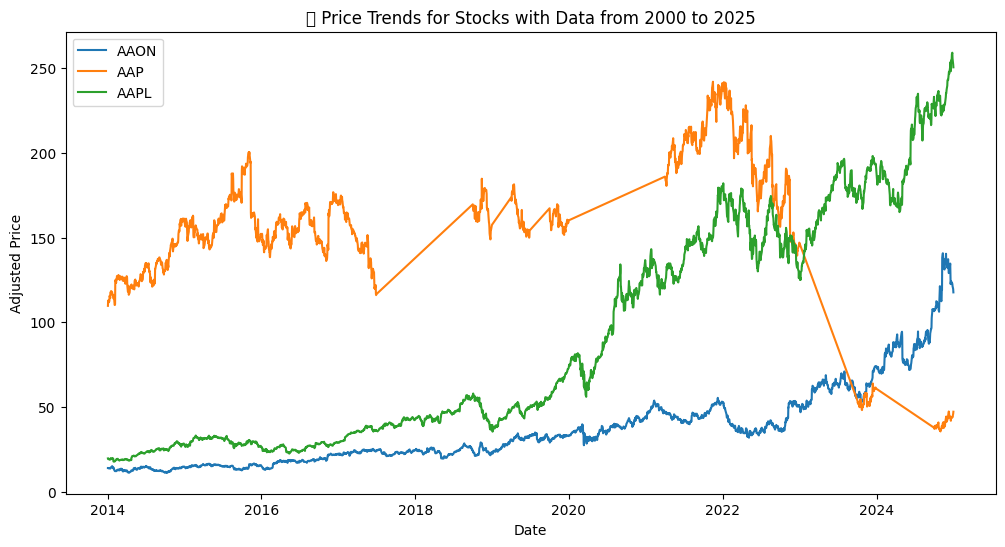

In [60]:
# Identify tickers with data from BOTH 2000 and 2025
tickers_with_full_span = (
    df_merged.groupby('ticker')['date']
    .agg(['min', 'max'])
    .query("min <= '2020-01-01' and max >= '2024-12-30'")
    .index.tolist()
)

print(f"Number of tickers with full span coverage: {len(tickers_with_full_span)}")

# Visualize Sample from These Tickers
sample_tickers = tickers_with_full_span[2:5]  # Select first 5 for visualization

plt.figure(figsize=(12, 6))
for ticker in sample_tickers:
    subset = df_merged[df_merged['ticker'] == ticker]
    plt.plot(subset['date'], subset['adj_prc'], label=ticker)

plt.legend()
plt.title("📈 Price Trends for Stocks with Data from 2000 to 2025")
plt.xlabel("Date")
plt.ylabel("Adjusted Price")
plt.show()

## 📚 **Volatility Analysis – Rolling vs. GARCH**

Understanding volatility is critical in portfolio management and risk assessment.  
In this section, we compare two approaches:

1. 📏 **Rolling (Historical) Volatility:**  
   - Simple method that calculates standard deviation over a fixed time window (e.g., last 20 days).
   - Assumes volatility changes slowly and doesn't account for sudden market shocks.

2. 📈 **GARCH (Generalized Autoregressive Conditional Heteroskedasticity):**  
   - Advanced model that dynamically estimates volatility based on past volatility and past shocks.
   - Captures **volatility clustering**, which is common in financial markets (periods of calm followed by high turbulence).

---

In [61]:
# 20-day rolling volatility
df_merged['rolling_vol_20d_daily'] = (
    df_merged.groupby('permno')['retx']
    .rolling(window=20, min_periods=15) # looks at past 20 days returns to calculate today's volatility
    .std()
    .reset_index(level=0, drop=True)
)


# Calculate 20-Day Rolling Volatility (Annualized)
df_merged['rolling_vol_20d'] = (
    df_merged.groupby('permno')['retx']
    .rolling(window=20, min_periods=15) # looks at past 20 days returns to calculate today's volatility
    .std()
    .reset_index(level=0, drop=True) * np.sqrt(252)  # Annualize
)

In [62]:
def calculate_garch_vol(series):
    if series.dropna().shape[0] < 50:
        return pd.Series(index=series.index, data=np.nan) # if there's not enough data (less than 100 days), skip calculation
    try:
        # prepare model, we are multiplying by 100 to express return in percentage
        model = arch_model(series.dropna() * 100, vol='Garch', p=1, q=1, dist='normal')

        # fit garch model to estimate volatility
        res = model.fit(disp='off')

        # gets model predicted volatility patterns
        forecasts = res.conditional_volatility / 100  # Scale back to normal scale

        forecasts = forecasts.shift(1)  # Use today's forecast for tomorrow's decision (avoid lookahead bias)
        
        forecasts.index = series.dropna().index # align forecast back to original dates
        return forecasts.reindex(series.index) # reindex to fill missing dates
    except:
        return pd.Series(index=series.index, data=np.nan)

# Compute GARCH Volatility Safely and Align Index
garch_vol_series = (
    df_merged.groupby('permno')['retx']
    .apply(calculate_garch_vol)
    .reset_index(level=0, drop=True)  # This flattens the index to match df_merged
)

# Now safely assign to the dataframe
df_merged['garch_vol'] = garch_vol_series

df_merged['garch_vol_annualized'] = df_merged['garch_vol'] * np.sqrt(252) # annualized

/Users/komalniraula/myenv/lib/python3.13/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.025. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/komalniraula/myenv/lib/python3.13/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03846. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/komalniraula/myenv/lib/python3.13/site-packages/arch/

In [67]:
## to compare which prediction is better

# Calculate Future Realized Volatility (5-Day)
df_merged['realized_vol_5d'] = ( # We are trying to predict the volatility for 5 days
    df_merged.groupby('permno')['retx']
    .rolling(window=5, min_periods=5)
    .std()   # standard deviation (avg volatility of next 5 days)
    .shift(-5)  # Look ahead 5 days
    .reset_index(level=0, drop=True)
)

# Compute future realized volatility over a 20-day horizon
df_merged['realized_vol_20d'] = (
    df_merged.groupby('permno')['retx']
    .rolling(window=20, min_periods=20)
    .std()
    .shift(-20)  # Align the 20-day future realized volatility with the prediction day
    .reset_index(level=0, drop=True)
) * np.sqrt(252)  # Annualized volatility to match GARCH if it’s also annualized

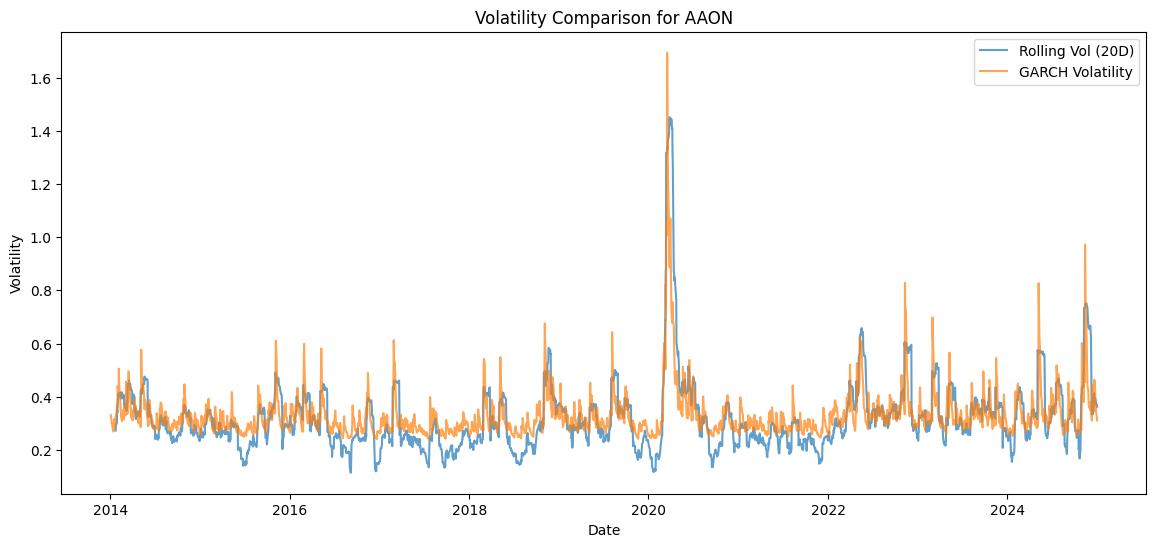

In [63]:
# Select a sample ticker for visualization
sample_ticker = tickers_with_full_span[2]  # Pick first ticker with full span

subset = df_merged[df_merged['ticker'] == sample_ticker]

plt.figure(figsize=(14, 6))
plt.plot(subset['date'], subset['rolling_vol_20d'], label='Rolling Vol (20D)', alpha=0.7)
plt.plot(subset['date'], subset['garch_vol_annualized'], label='GARCH Volatility', alpha=0.7)
plt.title(f"Volatility Comparison for {sample_ticker}")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.show()

In [69]:
valid_data = df_merged.dropna(subset=['garch_vol', 'rolling_vol_20d_daily', 'realized_vol_5d'])

mse_garch = mean_squared_error(valid_data['realized_vol_5d'], valid_data['garch_vol'])
mse_rolling = mean_squared_error(valid_data['realized_vol_5d'], valid_data['rolling_vol_20d_daily'])

print(f"📉 GARCH Forecast MSE: {mse_garch:.6f}")
print(f"📉 Rolling Volatility MSE: {mse_rolling:.6f}")

📉 GARCH Forecast MSE: 0.001072
📉 Rolling Volatility MSE: 0.001130


#### 📊 **Forecast Accuracy Comparison for AAPL**

| Model         | MSE (Lower is Better) |
|----------------|-----------------------|
| GARCH Volatility | 0.001072             |
| Rolling Volatility | 0.001130           |

- GARCH provided slightly better predictions of future volatility, but the difference is very small.



### Now let's look over entire stocks

**Analyze**:
   - For how many stocks does GARCH volatility provide better predictions?
   - For how many stocks does Rolling volatility perform better?
   - Compute the **average MSE** for both methods to assess overall performance.

This will help to decide which volatility model performs better at the stock level and across the entire market.

In [71]:
def calculate_and_analyze_mse(df, horizons=[5, 10, 20], realized_col='realized_vol_5d'):
    # Calculate Rolling Volatility for All Horizons (Daily)

    df = df[(df['date'] >= '2015-01-01') & (df['date'] <= '2021-12-31')].copy()
    
    for h in horizons:
        rolling_col = f'rolling_vol_{h}d_daily'
        if rolling_col not in df.columns:        
            df[rolling_col] = (
                df.groupby('permno')['retx']
                .rolling(window=h, min_periods=int(h * 0.75)) # looks at past 20 days returns to calculate today's volatility
                .std()
                .reset_index(level=0, drop=True)
            )

            

    # Calculate and Analyze MSE for Each Horizon
    for h in horizons:
        rolling_col = f'rolling_vol_{h}d_daily'
        mse_results = []

        for permno, group in df.groupby('permno'):
            data = group.dropna(subset=['garch_vol', rolling_col, realized_col])
            
            if not data.empty:
                mse_garch = mean_squared_error(data[realized_col], data['garch_vol'])
                mse_rolling = mean_squared_error(data[realized_col], data[rolling_col])
                
                mse_results.append({'permno': permno, 'mse_garch': mse_garch, f'mse_rolling_{h}d': mse_rolling})


        # Convert to DataFrame
        mse_df = pd.DataFrame(mse_results)
        
        if not mse_df.empty:
            garch_better_count = (mse_df['mse_garch'] < mse_df[f'mse_rolling_{h}d']).sum()
            rolling_better_count = (mse_df[f'mse_rolling_{h}d'] <= mse_df['mse_garch']).sum()

            avg_mse_garch = mse_df['mse_garch'].mean()
            avg_mse_rolling = mse_df[f'mse_rolling_{h}d'].mean()

            print(f"--- Horizon: {h} Days ---")
            print(f"📈 Number of stocks where GARCH performed better: {garch_better_count}")
            print(f"📉 Number of stocks where Rolling {h}D performed better: {rolling_better_count}")
            print(f"✅ Average MSE - GARCH: {avg_mse_garch:.6f}")
            print(f"✅ Average MSE - Rolling {h}D: {avg_mse_rolling:.6f}\n")
        else:
            print(f"⚠️ No valid data found for horizon {h} days.\n")



In [72]:
# Filter df_merged to only include data from 2014-11-01 onwards onwards
#df_merged = df_merged[df_merged['date'] >= pd.Timestamp('2014-11-01')].copy()

calculate_and_analyze_mse(df_merged, horizons=[5, 10, 20])

--- Horizon: 5 Days ---
📈 Number of stocks where GARCH performed better: 3897
📉 Number of stocks where Rolling 5D performed better: 415
✅ Average MSE - GARCH: 0.001423
✅ Average MSE - Rolling 5D: 0.001713

--- Horizon: 10 Days ---
📈 Number of stocks where GARCH performed better: 3533
📉 Number of stocks where Rolling 10D performed better: 779
✅ Average MSE - GARCH: 0.001431
✅ Average MSE - Rolling 10D: 0.001594

--- Horizon: 20 Days ---
📈 Number of stocks where GARCH performed better: 3145
📉 Number of stocks where Rolling 20D performed better: 1167
✅ Average MSE - GARCH: 0.001418
✅ Average MSE - Rolling 20D: 0.001492



> 📖 *Note: The difference in GARCH mse across different horizon is due to the changes in number of datapoints. This is because of the following column line: 
```python
data = group.dropna(subset=['garch_vol', rolling_col, realized_col])

### 📌 **Conclusion & Model Selection:**

- GARCH Volatility provided consistently lower forecast errors across most stocks
(especially 5-day horizon) with valid data.
- Rolling 5, 10, 20-Day volatility not only performed slightly worse but with higher average MSE, indicating poor predictive accuracy.
- ✅ **Decision:**  
We will use **GARCH Volatility** for further modeling and trading strategy development, as it has demonstrated superior predictive power in forecasting future realized volatility.

> 📖 *Note: This choice aligns with our objective of improving risk-adjusted returns through better volatility estimation and position sizing.*

### **Volatility and risk weighting**

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/1965747521.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['volatility_decile'] = pd.qcut(df_subset['garch_vol'], q=10, labels=[f'D{i+1}' for i in range(10)])
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/1965747521.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_returns = df_subset.groupby('volatility_decile')[future_return_col].mean().reset_index()


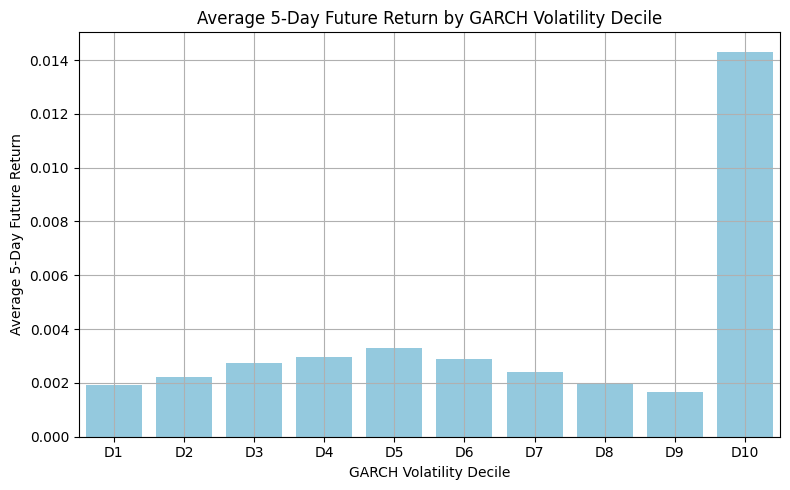

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/1965747521.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['volatility_decile'] = pd.qcut(df_subset['garch_vol'], q=10, labels=[f'D{i+1}' for i in range(10)])
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/1965747521.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_returns = df_subset.groupby('volatility_decile')[future_return_col].mean().reset_index()


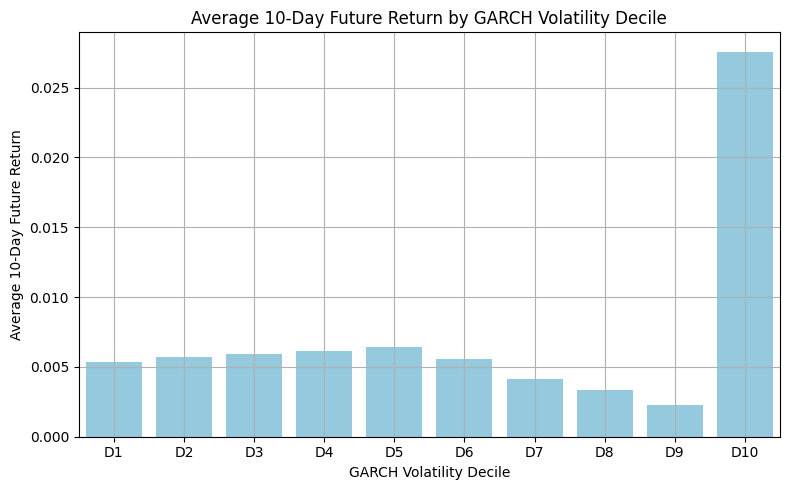

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/1965747521.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['volatility_decile'] = pd.qcut(df_subset['garch_vol'], q=10, labels=[f'D{i+1}' for i in range(10)])
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/1965747521.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_returns = df_subset.groupby('volatility_decile')[future_return_col].mean().reset_index()


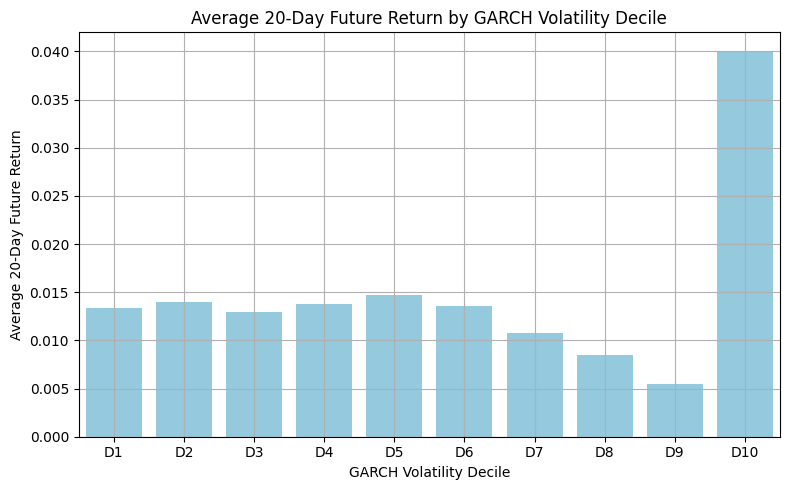

In [73]:
def calculate_future_returns(df, horizons=[5, 10, 20]):
    df_sorted = df.sort_values(['permno', 'date']).copy()
    for h in horizons:
        future_return_col = f'future_cumret_{h}d'
        df_sorted[future_return_col] = (
            df_sorted.groupby('permno')['retx']
            .transform(lambda x: x.shift(-1).rolling(window=h).sum())
        )
    return df_sorted

def analyze_garch_vol_vs_return_with_deciles(df, horizons=[5, 10, 20]):
    # Calculate future returns first
    df = calculate_future_returns(df, horizons)
    
    # Filter for 2015–2021 period
    df_filtered = df[(df['date'] >= '2015-01-01') & (df['date'] <= '2021-12-31')].dropna(subset=['garch_vol'])

    for h in horizons:
        future_return_col = f'future_cumret_{h}d'
        df_subset = df_filtered.dropna(subset=[future_return_col])

        # Create Decile Buckets
        df_subset['volatility_decile'] = pd.qcut(df_subset['garch_vol'], q=10, labels=[f'D{i+1}' for i in range(10)])

        # Compute Average Returns for Each Decile
        avg_returns = df_subset.groupby('volatility_decile')[future_return_col].mean().reset_index()

        # Plot
        plt.figure(figsize=(8, 5))
        sns.barplot(x='volatility_decile', y=future_return_col, data=avg_returns, color='skyblue')
        plt.title(f'Average {h}-Day Future Return by GARCH Volatility Decile')
        plt.xlabel('GARCH Volatility Decile')
        plt.ylabel(f'Average {h}-Day Future Return')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example Usage
analyze_garch_vol_vs_return_with_deciles(df_merged)

#### **Looking growth and value portfolio seperately**


📖 Analyzing Portfolio Type: Value
--------------------------------------------------


/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/1965747521.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['volatility_decile'] = pd.qcut(df_subset['garch_vol'], q=10, labels=[f'D{i+1}' for i in range(10)])
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/1965747521.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_returns = df_subset.groupby('volatility_decile')[future_return_col].mean().reset_index()


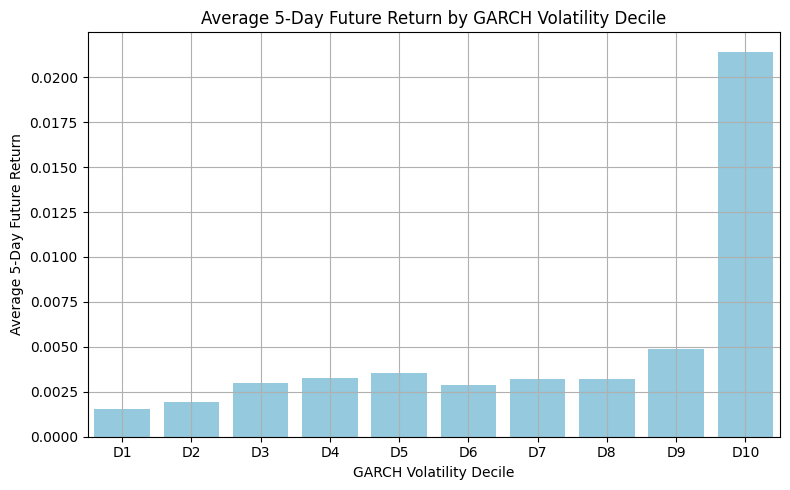

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/1965747521.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['volatility_decile'] = pd.qcut(df_subset['garch_vol'], q=10, labels=[f'D{i+1}' for i in range(10)])
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/1965747521.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_returns = df_subset.groupby('volatility_decile')[future_return_col].mean().reset_index()


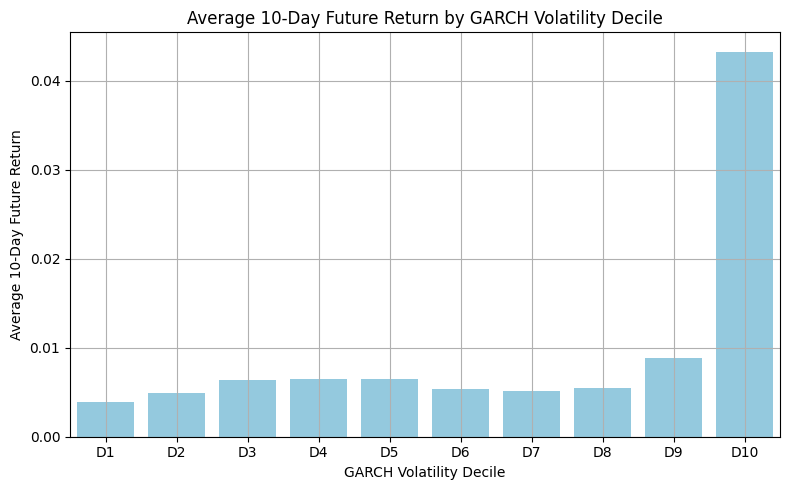

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/1965747521.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['volatility_decile'] = pd.qcut(df_subset['garch_vol'], q=10, labels=[f'D{i+1}' for i in range(10)])
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/1965747521.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_returns = df_subset.groupby('volatility_decile')[future_return_col].mean().reset_index()


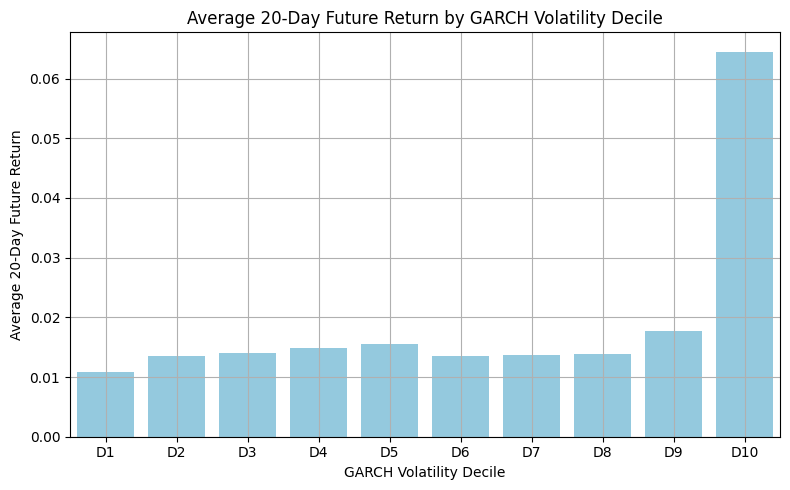


📖 Analyzing Portfolio Type: Growth
--------------------------------------------------


/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/1965747521.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['volatility_decile'] = pd.qcut(df_subset['garch_vol'], q=10, labels=[f'D{i+1}' for i in range(10)])
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/1965747521.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_returns = df_subset.groupby('volatility_decile')[future_return_col].mean().reset_index()


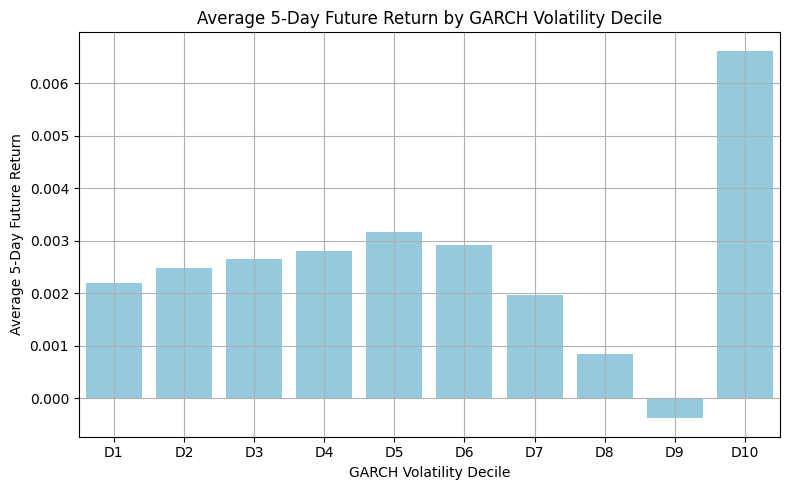

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/1965747521.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['volatility_decile'] = pd.qcut(df_subset['garch_vol'], q=10, labels=[f'D{i+1}' for i in range(10)])
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/1965747521.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_returns = df_subset.groupby('volatility_decile')[future_return_col].mean().reset_index()


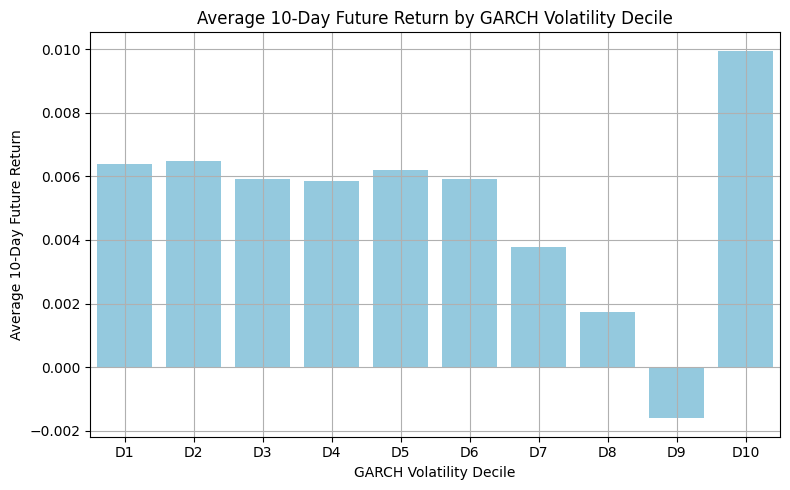

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/1965747521.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['volatility_decile'] = pd.qcut(df_subset['garch_vol'], q=10, labels=[f'D{i+1}' for i in range(10)])
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/1965747521.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_returns = df_subset.groupby('volatility_decile')[future_return_col].mean().reset_index()


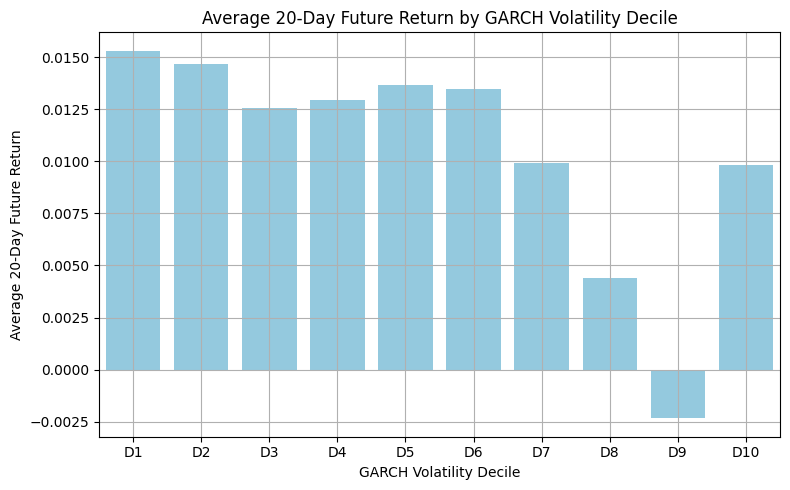

In [74]:

def analyze_by_portfolio_type(df, horizons=[5, 10, 20]):
    portfolio_types = df['portfolio_type'].unique()
    
    for p_type in portfolio_types:
        print(f"\n📖 Analyzing Portfolio Type: {p_type}\n" + "-" * 50)
        df_portfolio = df[df['portfolio_type'] == p_type]
        analyze_garch_vol_vs_return_with_deciles(df_portfolio, horizons=horizons)

# Example Usage
analyze_by_portfolio_type(df_merged)

In [75]:
# Distribution of return across volatility decile
def plot_avg_5day_return_distribution(df):
    df = calculate_future_returns(df, horizons=[5])
    df_filtered = df[(df['date'] >= '2015-01-01') & (df['date'] <= '2021-12-31')].dropna(subset=['garch_vol'])

    future_return_col = 'future_cumret_5d'
    df_filtered = df_filtered.dropna(subset=[future_return_col])
    df_filtered['volatility_decile'] = pd.qcut(df_filtered['garch_vol'], q=10, labels=[f'D{i+1}' for i in range(10)])

    # Compute average future return per decile
    avg_returns = df_filtered.groupby(['volatility_decile', 'permno'])[future_return_col].mean().reset_index()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='volatility_decile', y=future_return_col, data=avg_returns, palette='Blues')
    plt.title('Average 5-Day Future Return Distribution by GARCH Volatility Decile')
    plt.xlabel('GARCH Volatility Decile')
    plt.ylabel('Average 5-Day Future Return')
    plt.grid(True)
    plt.show()

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/2130193947.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_returns = df_filtered.groupby(['volatility_decile', 'permno'])[future_return_col].mean().reset_index()
/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1742/2130193947.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='volatility_decile', y=future_return_col, data=avg_returns, palette='Blues')


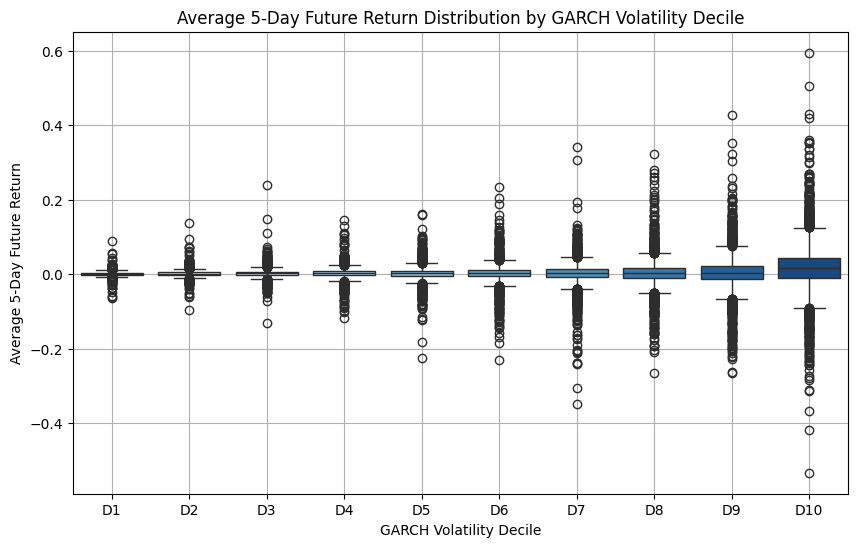

In [76]:
plot_avg_5day_return_distribution(df_merged)

### Backup data

In [77]:
df_copy = df_merged.copy() #storing backup, so i don't have start all over again if anything goes wrong

In [78]:
df_merged = df_copy.copy()
df_merged

,date,permno,ticker,prc,retx,shrout,cfacpr,vol,vwretd,vwretx,...,group_id,portfolio_type,adv20,adj_prc,rolling_vol_20d_daily,rolling_vol_20d,garch_vol,garch_vol_annualized,realized_vol_5d,realized_vol_20d
0,2014-01-02,10001,EGAS,8.04,0.001245,10452.0,1.0,729.00,-0.008757,-0.008884,...,2013-Q4-06,Value,729.0000,8.04,NaN,NaN,NaN,NaN,0.014757,0.305598
1,2014-01-03,10001,EGAS,8.18,0.017413,10452.0,1.0,489.00,0.000491,0.000436,...,2013-Q4-06,Value,609.0000,8.18,NaN,NaN,0.027947,0.443645,0.015645,0.303803
2,2014-01-06,10001,EGAS,8.34,0.019560,10452.0,1.0,645.00,-0.003340,-0.003360,...,2013-Q4-06,Value,621.0000,8.34,NaN,NaN,0.022227,0.352836,0.021374,0.316251
3,2014-01-07,10001,EGAS,8.77,0.051559,10452.0,1.0,2719.00,0.006090,0.006081,...,2013-Q4-06,Value,1145.5000,8.77,NaN,NaN,0.031760,0.504171,0.011213,0.280383
4,2014-01-08,10001,EGAS,8.96,0.021665,10452.0,1.0,1156.00,0.000155,-0.000040,...,2013-Q4-06,Value,1147.6000,8.96,NaN,NaN,0.033412,0.530396,0.009699,0.273349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5026484,2024-12-24,93436,TSLA,462.28,0.073572,3210060.0,1.0,593515.06,0.010566,0.010521,...,2024-Q3-06,Growth,875876.6060,462.28,0.038081,0.604524,0.044279,0.702910,NaN,NaN
5026485,2024-12-26,93436,TSLA,454.13,-0.017630,3210060.0,1.0,763922.73,0.000346,0.000282,...,2024-Q3-06,Growth,883066.3580,454.13,0.038657,0.613657,0.043716,0.693967,NaN,NaN
5026486,2024-12-27,93436,TSLA,431.66,-0.049479,3210060.0,1.0,823703.45,-0.010692,-0.010775,...,2024-Q3-06,Growth,895376.0835,431.66,0.040771,0.647215,0.044774,0.710763,NaN,NaN
5026487,2024-12-30,93436,TSLA,417.41,-0.033012,3210060.0,1.0,647054.52,-0.009878,-0.009900,...,2024-Q3-06,Growth,909094.5050,417.41,0.041681,0.661658,0.044171,0.701189,NaN,NaN


## 📖 **Ornstein-Uhlenbeck (OU) Return Forecast Analysis**

Now that we have determined GARCH volatility provides better risk estimation, we evaluate the predictive power of the **Ornstein-Uhlenbeck (OU) process** for return forecasting.



#### 📌 **What We Have Implemented**

We use the **Discrete-Time OU Forecast Formula** to estimate the expected return for the next day:

$$
\mathbb{E}[X_{t+1}] = X_t \cdot e^{-\theta} + \mu \cdot \left(1 - e^{-\theta}\right)
$$



- $X_t$: This is the **previous day's return**, taken from the `retx` column.
- We calculate $\theta$ and $\mu$ using the `estimate_ou_params` function.

| Parameter    | Meaning                 | How We Calculated and Used It |
|---------------|-------------------------|------------------------------|
| $\theta$    | **Speed of mean reversion**. Controls **how quickly returns move back toward their long-term average**. | Calculated **individually for each stock** using historical returns. Estimated via linear regression: first compute $\beta$ (coefficient) from $X_t = \beta X_{t-1} + c$, then calculate $\theta = -\ln(\beta)$. |
| $\mu$       | **Long-term mean return**. This is the return level each stock tends to revert to over time. | Calculated **individually for each stock** using $\mu = \frac{c}{1 - \beta}$, where $c$ is the intercept from the previous regression. |

- These parameters are computed **separately for each stock** based on its historical return data.


After calculating these parameters, we forecast the next day's return and store it in the `ou_forecast_return` column using:

```python
df_merged['ou_forecast_return'] = (
    df_merged['retx'].shift(1) * np.exp(-df_merged['theta']) +
    df_merged['mu'] * (1 - np.exp(-df_merged['theta']))
)
```

#### **Explanation of `np.exp(-θ)` in the Formula**

- `np.exp(-θ)` calculates the mathematical term $e^{-\theta}$.
- This term determines **how much weight is given to the previous day's return ($X_t$)** in the forecast.
    - If $\theta$ is small, $e^{-\theta}$ is close to 1, and the forecast relies more on the previous return.
    - If $\theta$ is large, $e^{-\theta}$ becomes small, and the forecast relies more on the long-term mean $\mu$.

- In simple terms:
    - A **small $\theta$** means slow mean reversion, so the forecast stays closer to yesterday’s return.
    - A **large $\theta$** means fast mean reversion, so the forecast moves quickly toward the historical average return.





In [80]:
def estimate_ou_params(series):
    series = series.dropna()
    if len(series) < 10:
        return None, None

    recent_series = series.tail(10)
    x_lag = recent_series.shift(1).dropna()
    x_current = recent_series.loc[x_lag.index]

    if x_lag.empty or x_current.empty:
        return None, None

    X = np.vstack([x_lag.values, np.ones(len(x_lag))]).T
    try:
        beta, c = np.linalg.lstsq(X, x_current.values, rcond=None)[0]
    except np.linalg.LinAlgError:
        return None, None

    if beta <= 0 or beta >= 1:
        return None, None

    θ = -np.log(beta)
    μ = c / (1 - beta)
    return θ, μ

def process_stock_ou_params(permno, stock_data):
    stock_data = stock_data.sort_values('date')
    results = []

    for idx, row in stock_data.iterrows():
        current_date = row['date']
        historical_data = stock_data[stock_data['date'] < current_date]['retx'].tail(10)

        θ, μ = estimate_ou_params(historical_data)
        results.append({
            'permno': permno,
            'date': current_date,
            'theta': θ,
            'mu': μ
        })

    return results

def calculate_rolling_ou_params_parallel(df, n_jobs=4):
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.sort_values(['permno', 'date'])

    grouped = list(df.groupby('permno'))

    results = Parallel(n_jobs=n_jobs)(
        delayed(process_stock_ou_params)(permno, group)
        for permno, group in tqdm(grouped, desc="Processing OU Params")
    )

    # Flatten results
    return pd.DataFrame([item for sublist in results for item in sublist])

In [81]:
ou_params_df = calculate_rolling_ou_params_parallel(df_merged, n_jobs=4)

Processing OU Params:  65%|███████████      | 3144/4829 [03:10<02:05, 13.42it/s]

KeyboardInterrupt: 

In [ ]:
# Merge OU Parameters Back to Main Data
df_merged = df_merged.merge(ou_params_df, on=['permno', 'date'], how='left')

#print(df_merged)
# OU Forecast uses only past returns and previously calculated OU parameters (no future data used)
df_merged['ou_forecast_return'] = (
    df_merged['retx'].shift(1) * np.exp(-df_merged['theta']) +
    df_merged['mu'] * (1 - np.exp(-df_merged['theta']))
)

In [ ]:
def calculate_future_cumulative_returns(df, horizons=[5, 10, 20]):
    """
    Calculates future cumulative returns for specified horizons.

    Parameters:
    - df: DataFrame with 'retx', 'permno', and 'date' columns.
    - horizons: List of horizons in days (e.g., [5, 10, 20]).

    Returns:
    - DataFrame with new columns 'future_cumret_Xd'.
    """
    df = df.sort_values(['permno', 'date']).copy()

    for h in horizons:
        # Calculate future cumulative returns: Product of (1 + daily return) over horizon, minus 1
        df[f'future_cumret_{h}d'] = (
            df.groupby('permno')['retx']
            .transform(lambda x: x.shift(-1).rolling(window=h).apply(lambda r: np.prod(1 + r) - 1, raw=True))
        )
    return df

In [ ]:
def calculate_z_scores_for_group(group, horizons, lookback_periods):
    group = group.sort_values('date').copy()

    for h in horizons:
        future_return_col = f'future_cumret_{h}d'

        for lb in lookback_periods:
            # Avoid lookahead bias using .shift(1)
            rolling_std = group['retx'].shift(1).rolling(window=lb).std()

            # Classical Z-Score
            group[f'z_classical_{h}d_lb{lb}'] = group[future_return_col] / rolling_std

            # OU-Based Z-Score
            if 'ou_forecast_return' not in group.columns:
                raise ValueError("Missing 'ou_forecast_return'. Compute it before calculating OU-based z-scores.")

            group[f'z_ou_{h}d_lb{lb}'] = (
                (group[future_return_col] - group['ou_forecast_return']) / rolling_std
            )
    return group

def calculate_individual_z_scores_parallel(df, horizons=[5, 10, 20], lookback_periods=[5, 10, 20], n_jobs=2):
    groups = [group for _, group in df.groupby('permno')]

    # Use tqdm for progress tracking with parallel computing
    parallel_results = Parallel(n_jobs=n_jobs, backend='loky')(
        delayed(calculate_z_scores_for_group)(group, horizons, lookback_periods) for group in tqdm(groups, desc="Processing Groups")
    )

    return pd.concat(parallel_results).reset_index(drop=True)

In [ ]:
df_merged = calculate_future_cumulative_returns(df_merged, horizons=[5, 10, 20])

In [ ]:
horizons = [5, 10, 20]
lookback_periods = [5, 10, 20]

df_with_zscores = calculate_individual_z_scores_parallel(
    df=df_merged, 
    horizons=horizons, 
    lookback_periods=lookback_periods,
    n_jobs=4
)
df_with_zscores

### Spread based zscore 

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Import Dask
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster

# Disable pyarrow strings in Dask
import dask
dask.config.set({'dataframe.convert-string': False})

def calculate_quarterly_spreads_with_dask(df_pairs, df_merged, n_jobs):
    """Calculate spreads using only pandas and Dask (no Polars or PyArrow)"""
    print("Starting pandas + Dask optimized spread calculation...")
    
    # Ensure date column is datetime
    df_merged['date'] = pd.to_datetime(df_merged['date'])
    
    # Add quarter column if not present
    if 'quarter' not in df_merged.columns:
        df_merged['quarter'] = df_merged['date'].dt.quarter
    
    # Get unique permnos from pairs
    unique_permnos1 = df_pairs['permno_1'].unique()
    unique_permnos2 = df_pairs['permno_2'].unique()
    needed_permnos = set(unique_permnos1) | set(unique_permnos2)
    
    # Filter to only needed permnos and columns
    df_prices = df_merged[df_merged['permno'].isin(needed_permnos)][['permno', 'date', 'adj_prc', 'quarter']]
    
    # Create a dictionary of price dataframes for fast lookups
    print("Creating price lookup dictionary...")
    permno_to_prices = {}
    for permno in tqdm(needed_permnos):
        permno_prices = df_prices[df_prices['permno'] == permno][['date', 'adj_prc', 'quarter']]
        permno_to_prices[permno] = permno_prices
    
    # Free memory
    del df_merged, df_prices
    gc.collect()
    
    # Process pairs in parallel but NOT using Dask for the dataframe conversion
    print(f"Setting up processing with {n_jobs} workers...")
    
    # Process in chunks to avoid Dask's pyarrow dependency
    chunks = np.array_split(df_pairs.index, n_jobs)
    
    def process_chunk(chunk_indices):
        results = []
        chunk_df = df_pairs.loc[chunk_indices]
        
        for _, row in chunk_df.iterrows():
            p1, p2, group_id = row['permno_1'], row['permno_2'], row['group_id']
            
            # Skip if either stock doesn't have price data
            if p1 not in permno_to_prices or p2 not in permno_to_prices:
                continue
                
            # Get price data for both stocks
            p1_prices = permno_to_prices[p1].copy()
            p1_prices.rename(columns={'adj_prc': 'price_p1'}, inplace=True)
            
            p2_prices = permno_to_prices[p2].copy()
            p2_prices.rename(columns={'adj_prc': 'price_p2'}, inplace=True)
            
            # Merge on date and quarter
            merged = pd.merge(
                p1_prices, 
                p2_prices, 
                on=['date', 'quarter'], 
                how='inner'
            )
            
            # Calculate spread
            merged['spread'] = merged['price_p1'] - merged['price_p2']
            
            # Add identifiers
            merged['permno_1'] = p1
            merged['permno_2'] = p2
            merged['group_id'] = group_id
            
            # Select only needed columns
            result = merged[['group_id', 'permno_1', 'permno_2', 'date', 'quarter', 'spread']]
            results.append(result)
        
        if results:
            return pd.concat(results, ignore_index=True)
        else:
            return pd.DataFrame(columns=['group_id', 'permno_1', 'permno_2', 'date', 'quarter', 'spread'])
    
    # Use joblib for parallelization instead of Dask
    print("Computing spreads with joblib parallelization...")
    chunk_results = Parallel(n_jobs=n_jobs)(
        delayed(process_chunk)(chunk) for chunk in chunks
    )
    
    # Combine results
    df_spreads = pd.concat(chunk_results, ignore_index=True)
    
    print(f"Spread calculation complete. Shape: {df_spreads.shape}")
    
    return df_spreads

def calculate_ou_params_with_joblib(df_spreads, n_jobs=4):
    """Calculate OU parameters using joblib parallelization (no Dask or Polars)"""
    print("Starting joblib-optimized OU parameter calculation...")
    
    # Ensure date is datetime
    df_spreads['date'] = pd.to_datetime(df_spreads['date'])
    
    # Convert quarter to string for sorting if needed
    df_spreads['quarter_str'] = df_spreads['quarter'].astype(str)
    
    # Get unique pairs
    unique_pairs = df_spreads[['group_id', 'permno_1', 'permno_2']].drop_duplicates().reset_index(drop=True)
    print(f"Processing {len(unique_pairs)} unique pairs")
    
    # Function to estimate OU parameters for a series
    def estimate_ou_params(series):
        series = series.dropna()
        if len(series) < 30:
            return None, None, None
            
        # Use the most recent data
        recent_series = series.tail(30)
        
        # Prepare lagged data for regression
        x_lag = recent_series.shift(1).dropna()
        x_current = recent_series.loc[x_lag.index]
        
        if x_lag.empty or x_current.empty or len(x_lag) < 5:
            return None, None, None
            
        # Perform regression
        X = np.vstack([x_lag.values, np.ones(len(x_lag))]).T
        try:
            beta, c = np.linalg.lstsq(X, x_current.values, rcond=None)[0]
        except np.linalg.LinAlgError:
            return None, None, None
            
        # Validate regression results
        if beta <= 0 or beta >= 1:
            return None, None, None
            
        # Calculate OU parameters
        θ = -np.log(beta)
        μ = c / (1 - beta)
        half_life = np.log(2) / θ
        
        return θ, μ, half_life
    
    # Function to process all quarters for a pair
    def process_pair_quarters(row):
        group_id, permno_1, permno_2 = row['group_id'], row['permno_1'], row['permno_2']
        
        # Get data for this pair
        pair_data = df_spreads[
            (df_spreads['group_id'] == group_id) & 
            (df_spreads['permno_1'] == permno_1) & 
            (df_spreads['permno_2'] == permno_2)
        ].sort_values('date').copy()
        
        # Get unique quarters in chronological order
        quarters = sorted(pair_data['quarter_str'].unique())
        
        results = []
        
        # Process each quarter except the first
        for i in range(1, len(quarters)):
            current_quarter = quarters[i]
            current_quarter_obj = pair_data[pair_data['quarter_str'] == current_quarter]['quarter'].iloc[0]
            
            # Get data up to the end of previous quarter
            prev_data = pair_data[pair_data['quarter_str'] <= quarters[i-1]]
            
            # Skip if not enough data
            if len(prev_data) < 30:
                continue
                
            # Get last 30 days for parameter estimation
            hist_spread = prev_data['spread'].tail(30)
            
            # Estimate OU parameters
            θ, μ, half_life = estimate_ou_params(hist_spread)
            
            # Skip if any parameter is None or half-life is > 20
            if θ is None or μ is None or half_life is None or half_life > 20:
                continue
                
            # Add result
            results.append({
                'group_id': group_id,
                'permno_1': permno_1,
                'permno_2': permno_2,
                'quarter': current_quarter_obj,
                'theta': θ,
                'mu': μ,
                'half_life': half_life
            })
        
        return results
    
    # Process in chunks using joblib instead of Dask
    chunks = np.array_split(unique_pairs.index, n_jobs)
    
    def process_chunk(chunk_indices):
        results = []
        chunk_df = unique_pairs.loc[chunk_indices]
        
        for _, row in chunk_df.iterrows():
            pair_results = process_pair_quarters(row)
            results.extend(pair_results)
        
        return results
    
    # Use joblib for parallelization
    print("Computing OU parameters with joblib parallelization...")
    all_results = Parallel(n_jobs=n_jobs)(
        delayed(process_chunk)(chunk) for chunk in chunks
    )
    
    # Flatten results and create DataFrame
    flattened_results = [item for sublist in all_results for item in sublist]
    ou_params_df = pd.DataFrame(flattened_results)
    
    print(f"OU parameter calculation complete. Shape: {ou_params_df.shape}")
    
    return ou_params_df

# Simple function for saving to parquet that avoids pyarrow
def save_to_csv(df, filename):
    """Save DataFrame to CSV instead of parquet to avoid pyarrow dependency"""
    csv_filename = filename.replace('.parquet', '.csv')
    df.to_csv(csv_filename, index=False)
    return csv_filename

# Main execution flow
def main_super_optimized_joblib():
    # Calculate spreads with joblib optimization (no Dask or Polars)
    df_spreads = calculate_quarterly_spreads_with_dask(
        df_pairs, 
        df_merged, 
        n_jobs=4
    )
    
    # Save spreads to CSV instead of parquet
    csv_file = save_to_csv(df_spreads, 'spreads.parquet')
    print(f"Spreads saved to {csv_file}")
    
    # Calculate OU parameters with joblib
    ou_params_df = calculate_ou_params_with_joblib(
        df_spreads,
        n_jobs=4
    )
    
    # Save OU parameters to CSV
    csv_file = save_to_csv(ou_params_df, 'ou_params.parquet')
    print(f"OU parameters saved to {csv_file}")
    
    return ou_params_df

# Execute the workflow
if __name__ == "__main__":
    start_time = pd.Timestamp.now()
    print(f"Starting joblib-optimized processing at {start_time}")
    
    ou_params_df = main_super_optimized_joblib()
    
    end_time = pd.Timestamp.now()
    print(f"Completed in {end_time - start_time}")

Starting joblib-optimized processing at 2025-05-15 06:16:27.050169
Starting pandas + Dask optimized spread calculation...
Creating price lookup dictionary...


  0%|          | 0/3911 [00:00<?, ?it/s]

Setting up processing with 4 workers...
Computing spreads with joblib parallelization...
Spread calculation complete. Shape: (292099903, 6)
Spreads saved to spreads.csv
Starting joblib-optimized OU parameter calculation...
Processing 265334 unique pairs
Computing OU parameters with joblib parallelization...


Python(2287) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(2288) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(2289) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(2290) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


#### Previous block takes too long, if it saves spreads and stops:

In [ ]:
def load_spreads_and_calculate_ou_params(spreads_csv_path, n_jobs=4, batch_size=10000):
    """
    Load spread data from CSV and efficiently calculate OU parameters
    with improved progress monitoring
    
    Parameters:
    spreads_csv_path: Path to the CSV file containing spread data
    n_jobs: Number of parallel jobs
    batch_size: Number of unique pairs to process in each batch for memory efficiency
    
    Returns:
    DataFrame with OU parameters
    """
    start_time = pd.Timestamp.now()
    print(f"Starting OU parameter calculation at {start_time}")
    
    # Load spreads data efficiently (use chunksize for very large files)
    print(f"Loading spreads from {spreads_csv_path}...")
    
    # First read a small sample to understand the data types
    sample_df = pd.read_csv(spreads_csv_path, nrows=1000)
    print(f"Columns in spreads file: {sample_df.columns.tolist()}")
    print(f"Sample data types: {sample_df.dtypes}")
    
    # Check file size to determine if we should use chunking
    file_size_gb = os.path.getsize(spreads_csv_path) / (1024**3)
    print(f"File size: {file_size_gb:.2f} GB")
    
    if file_size_gb > 2:  # If file is larger than 2 GB
        print(f"Large file detected. Loading in chunks...")
        
        # Create a safer dtypes dictionary - handle group_id as string
        dtypes = {}
        for col in sample_df.columns:
            if col == 'group_id':
                dtypes[col] = 'str'  # Always treat group_id as string
            elif col in ['permno_1', 'permno_2', 'quarter']:
                dtypes[col] = 'int32'
            elif col == 'spread':
                dtypes[col] = 'float32'
        
        # Read unique pair identifiers first to plan processing
        print("Scanning file for unique pairs...")
        unique_pairs = pd.DataFrame()
        
        # Using just the columns we need
        usecols = ['group_id', 'permno_1', 'permno_2']
        
        for chunk in tqdm(pd.read_csv(spreads_csv_path, usecols=usecols, 
                                      dtype=dtypes, chunksize=1000000)):
            chunk_unique = chunk[usecols].drop_duplicates()
            unique_pairs = pd.concat([unique_pairs, chunk_unique])
            unique_pairs = unique_pairs.drop_duplicates()
        
        # Reset index for efficient access
        unique_pairs = unique_pairs.reset_index(drop=True)
        print(f"Found {len(unique_pairs)} unique pairs to process")
        
    else:
        # For smaller files, load the entire dataset at once
        print("Loading entire spreads file into memory...")
        df_spreads = pd.read_csv(spreads_csv_path)
        
        # Optimize memory usage
        df_spreads['date'] = pd.to_datetime(df_spreads['date'])
        
        # Safely convert numeric columns
        for col in df_spreads.select_dtypes(include=['int64']).columns:
            if col != 'group_id':  # Skip group_id if it's numeric but has special formats
                df_spreads[col] = df_spreads[col].astype('int32')
                
        for col in df_spreads.select_dtypes(include=['float64']).columns:
            df_spreads[col] = df_spreads[col].astype('float32')
        
        # Get unique pairs
        unique_pairs = df_spreads[['group_id', 'permno_1', 'permno_2']].drop_duplicates().reset_index(drop=True)
        print(f"Processing {len(unique_pairs)} unique pairs")
    
    # Function to estimate OU parameters for a series
    def estimate_ou_params(series):
        series = series.dropna()
        if len(series) < 30:
            return None, None, None
            
        # Use the most recent data
        recent_series = series.tail(30)
        
        # Prepare lagged data for regression
        x_lag = recent_series.shift(1).dropna()
        x_current = recent_series.loc[x_lag.index]
        
        if x_lag.empty or x_current.empty or len(x_lag) < 5:
            return None, None, None
            
        # Perform regression
        X = np.vstack([x_lag.values, np.ones(len(x_lag))]).T
        try:
            beta, c = np.linalg.lstsq(X, x_current.values, rcond=None)[0]
        except np.linalg.LinAlgError:
            return None, None, None
            
        # Validate regression results
        if beta <= 0 or beta >= 1:
            return None, None, None
            
        # Calculate OU parameters
        θ = -np.log(beta)
        μ = c / (1 - beta)
        half_life = np.log(2) / θ
        
        return θ, μ, half_life
    
    # Function to process a single pair from the CSV file
    def process_pair_from_csv(row, file_path):
        group_id, permno_1, permno_2 = row['group_id'], row['permno_1'], row['permno_2']
        
        try:
            # Read only data for this pair - handle group_id appropriately
            if isinstance(group_id, str):
                # If group_id is string, we need to escape quotes
                group_id_str = f"'{group_id}'"
            else:
                group_id_str = str(group_id)
                
            query_string = f"group_id == {group_id_str} and permno_1 == {permno_1} and permno_2 == {permno_2}"
            
            # Read with pandas query
            pair_data = pd.read_csv(
                file_path,
                usecols=['group_id', 'permno_1', 'permno_2', 'date', 'quarter', 'spread']
            )
            
            # Filter after reading to avoid query issues
            pair_data = pair_data[
                (pair_data['group_id'] == group_id) & 
                (pair_data['permno_1'] == permno_1) & 
                (pair_data['permno_2'] == permno_2)
            ]
            
            # Convert date to datetime
            pair_data['date'] = pd.to_datetime(pair_data['date'])
            
            # Sort by date
            pair_data = pair_data.sort_values('date')
            
            # Process OU parameters for this pair
            return process_pair_quarters(pair_data)
            
        except Exception as e:
            print(f"Error processing pair {group_id}-{permno_1}-{permno_2}: {str(e)}")
            return []
    
    # Function to process all quarters for a pair
    def process_pair_quarters(pair_data):
        # Check if we have data
        if len(pair_data) == 0:
            return []
            
        # Extract identifiers
        group_id = pair_data['group_id'].iloc[0]
        permno_1 = pair_data['permno_1'].iloc[0]
        permno_2 = pair_data['permno_2'].iloc[0]
        
        # Convert quarter to string for easier sorting
        pair_data['quarter_str'] = pair_data['quarter'].astype(str)
        
        # Get unique quarters in chronological order
        quarters = sorted(pair_data['quarter_str'].unique())
        
        # Skip if we don't have at least 2 quarters
        if len(quarters) < 2:
            return []
        
        results = []
        
        # Process each quarter except the first
        for i in range(1, len(quarters)):
            current_quarter = quarters[i]
            current_quarter_obj = pair_data[pair_data['quarter_str'] == current_quarter]['quarter'].iloc[0]
            
            # Get data up to the end of previous quarter
            prev_data = pair_data[pair_data['quarter_str'] <= quarters[i-1]]
            
            # Skip if not enough data
            if len(prev_data) < 30:
                continue
                
            # Get last 30 days for parameter estimation
            hist_spread = prev_data['spread'].tail(30)
            
            # Estimate OU parameters
            θ, μ, half_life = estimate_ou_params(hist_spread)
            
            # Skip if any parameter is None or half-life is > 20
            if θ is None or μ is None or half_life is None or half_life > 20:
                continue
                
            # Add result
            results.append({
                'group_id': group_id,
                'permno_1': permno_1,
                'permno_2': permno_2,
                'quarter': current_quarter_obj,
                'theta': θ,
                'mu': μ,
                'half_life': half_life
            })
        
        return results
    
    # Process in batches for memory efficiency
    results = []
    
    # Calculate number of batches
    num_batches = (len(unique_pairs) + batch_size - 1) // batch_size
    
    # Create a global progress bar for batches
    batch_progress = tqdm(total=num_batches, desc="Processing batches", position=0)
    
    # Process each batch
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(unique_pairs))
        
        batch_pairs = unique_pairs.iloc[start_idx:end_idx].reset_index(drop=True)
        
        if file_size_gb > 2:
            # For large files, each worker reads directly from CSV
            batch_results = Parallel(n_jobs=n_jobs)(
                delayed(process_pair_from_csv)(row, spreads_csv_path) 
                for _, row in batch_pairs.iterrows()
            )
        else:
            # For smaller files, process from the loaded dataframe
            def process_loaded_pair(row):
                group_id, permno_1, permno_2 = row['group_id'], row['permno_1'], row['permno_2']
                
                # Get data for this pair
                pair_data = df_spreads[
                    (df_spreads['group_id'] == group_id) & 
                    (df_spreads['permno_1'] == permno_1) & 
                    (df_spreads['permno_2'] == permno_2)
                ].sort_values('date').copy()
                
                return process_pair_quarters(pair_data)
            
            # Create a pair processing progress bar
            pair_progress = tqdm(total=len(batch_pairs), 
                                 desc=f"Batch {batch_idx+1}/{num_batches}", 
                                 position=1, 
                                 leave=False)
            
            # Process this batch with progress updates
            batch_results = []
            for _, row in batch_pairs.iterrows():
                result = process_loaded_pair(row)
                batch_results.append(result)
                pair_progress.update(1)
            
            pair_progress.close()
        
        # Flatten batch results and extend main results list
        batch_flattened = [item for sublist in batch_results for item in sublist]
        results.extend(batch_flattened)
        
        # Update batch progress
        batch_progress.update(1)
        batch_progress.set_postfix({"Parameters": len(results)})
        
        # Force garbage collection between batches
        gc.collect()
    
    batch_progress.close()
    
    # Convert results to DataFrame
    ou_params_df = pd.DataFrame(results) if results else pd.DataFrame(columns=[
        'group_id', 'permno_1', 'permno_2', 'quarter', 'theta', 'mu', 'half_life'
    ])
    
    end_time = pd.Timestamp.now()
    print(f"OU parameter calculation completed in {end_time - start_time}")
    print(f"Found {len(ou_params_df)} valid OU parameters")
    
    return ou_params_df

# Main function to execute the OU parameter calculation
def main_calculate_ou_params():
    start_time = pd.Timestamp.now()
    print(f"Starting OU parameter calculation at {start_time}")
    
    # Load spreads and calculate OU parameters
    ou_params_df = load_spreads_and_calculate_ou_params(
        spreads_csv_path='spreads.csv',
        n_jobs=4,  # Adjust based on your CPU
        batch_size=2000  # Adjust based on your memory
    )
    
    # Save OU parameters to CSV
    ou_params_df.to_csv('ou_params.csv', index=False)
    print(f"OU parameters saved to ou_params.csv")
    
    end_time = pd.Timestamp.now()
    print(f"Completed in {end_time - start_time}")
    
    return ou_params_df

# Execute the workflow
if __name__ == "__main__":
    ou_params_df = main_calculate_ou_params()

Starting OU parameter calculation at 2025-05-15 07:10:32.487353
Starting OU parameter calculation at 2025-05-15 07:10:32.487451
Loading spreads from spreads.csv...
Columns in spreads file: ['group_id', 'permno_1', 'permno_2', 'date', 'quarter', 'spread']
Sample data types: group_id     object
permno_1      int64
permno_2      int64
date         object
quarter      object
spread      float64
dtype: object
File size: 14.97 GB
Large file detected. Loading in chunks...
Scanning file for unique pairs...


0it [00:00, ?it/s]

Found 265334 unique pairs to process


Processing batches:   0%|          | 0/133 [00:00<?, ?it/s]

### **Merge with fed rates data**

In [42]:
df_with_zscores['date'] = pd.to_datetime(df_with_zscores['date'])
df_final = df_with_zscores[df_with_zscores['date'] >= pd.Timestamp('2015-01-01')].copy()

In [43]:
market_returns = df_merged[['date', 'vwretd']].drop_duplicates().set_index('date')['vwretd']
market_returns.to_csv('market_returns.csv', index = False)
market_returns

date
2014-01-02   -0.008757
2014-01-03    0.000491
2014-01-06   -0.003340
2014-01-07    0.006090
2014-01-08    0.000155
                ...   
2024-09-24    0.003021
2024-09-25   -0.003168
2024-09-26    0.004793
2024-09-27   -0.000638
2024-09-30    0.003106
Name: vwretd, Length: 2768, dtype: float64

In [44]:
df_fed = pd.read_csv('fed_rates.csv')
df_fed['date'] = pd.to_datetime(df_fed['date'])

# Merge on 'date'
df_final = df_final.merge(df_fed, on='date', how='left')

# Preview merged DataFrame
df_final

,date,permno,ticker,prc,retx,shrout,cfacpr,vol,vwretd,vwretx,...,z_ou_10d_lb10,z_classical_10d_lb20,z_ou_10d_lb20,z_classical_20d_lb5,z_ou_20d_lb5,z_classical_20d_lb10,z_ou_20d_lb10,z_classical_20d_lb20,z_ou_20d_lb20,fed_funds_rate
0,2015-01-02,10001,EGAS,11.02,0.000000,10488.0,1.0,86.44,-0.000242,-0.000387,...,NaN,1.330051,NaN,5.176951,NaN,4.239303,NaN,3.270822,NaN,0.12
1,2015-01-05,10001,EGAS,11.02,0.000000,10488.0,1.0,76.41,-0.018276,-0.018328,...,NaN,-0.896582,NaN,8.558579,NaN,3.273479,NaN,2.259211,NaN,0.12
2,2015-01-06,10001,EGAS,10.90,-0.010889,10488.0,1.0,375.76,-0.009661,-0.009663,...,NaN,-0.775875,NaN,14.432245,NaN,3.445510,NaN,2.203966,NaN,0.12
3,2015-01-07,10001,EGAS,10.92,0.001835,10488.0,1.0,264.86,0.011114,0.010908,...,NaN,-0.404262,NaN,7.843894,NaN,5.922751,NaN,2.776095,NaN,0.12
4,2015-01-08,10001,EGAS,10.98,0.005494,10488.0,1.0,263.32,0.016844,0.016817,...,NaN,0.177042,NaN,7.625487,NaN,5.972548,NaN,2.823700,NaN,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4581417,2024-12-24,93436,TSLA,462.28,0.073572,3210060.0,1.0,593515.06,0.010566,0.010521,...,1.286249,1.841114,1.574595,7.198715,6.988515,7.455988,7.238276,9.127442,8.860923,4.33
4581418,2024-12-26,93436,TSLA,454.13,-0.017630,3210060.0,1.0,763922.73,0.000346,0.000282,...,0.343909,0.851681,0.450662,5.036901,4.777652,5.945723,5.639697,7.791329,7.390310,4.33
4581419,2024-12-27,93436,TSLA,431.66,-0.049479,3210060.0,1.0,823703.45,-0.010692,-0.010775,...,-1.083224,-1.116020,-1.353317,4.908765,4.693650,4.334232,4.144294,5.414937,5.177640,4.33
4581420,2024-12-30,93436,TSLA,417.41,-0.033012,3210060.0,1.0,647054.52,-0.009878,-0.009900,...,-2.302150,-3.134918,-2.891714,2.634350,2.833871,2.556434,2.750053,3.211119,3.454322,4.33


In [45]:
df_final.to_csv('final_backtest_data.csv', index = False)

### **Correlation and cointegration**

In [82]:
def calculate_correlation_for_group(group_df, group_id, min_overlap=30):
    result = []
    returns = group_df.pivot_table(index='date', columns='permno', values='retx')

    # Get stock pairs using combinations
    stocks = returns.columns
    for stock1, stock2 in combinations(stocks, 2):
        series1 = returns[stock1].dropna()
        series2 = returns[stock2].dropna()
        common_dates = series1.index.intersection(series2.index)

        if len(common_dates) >= min_overlap:
            corr = series1.loc[common_dates].corr(series2.loc[common_dates])
            result.append({
                'group_id': group_id,
                'permno_1': stock1,
                'permno_2': stock2,
                'correlation': corr
            })
    return result

def process_group(group_id, df, min_overlap):
    group_df = df[df['group_id'] == group_id]
    return calculate_correlation_for_group(group_df, group_id, min_overlap)  # Assuming this function exists

def calculate_correlations_parallel(df, min_overlap=30, n_jobs=4):
    groups = list(df['group_id'].unique())

    results = []
    with tqdm(total=len(groups), desc="Processing Groups") as pbar:
        parallel = Parallel(n_jobs=n_jobs, backend='loky')
        tasks = (delayed(process_group)(group_id, df, min_overlap) for group_id in groups)
        for res in parallel(tasks):
            results.append(res)
            pbar.update(1)

    # Flatten results
    flat_results = [item for sublist in results for item in sublist]
    return pd.DataFrame(flat_results)

In [63]:
correlation_df = calculate_correlations_parallel(df_with_zscores, min_overlap=30, n_jobs=4)


Processing Groups: 100%|██████████████████████| 229/229 [27:10<00:00,  7.12s/it]


In [71]:
correlation_df.to_csv('correlation.csv', index=False) # saving for backup

In [83]:
def calculate_half_life(spread_series):
    spread_lag = spread_series.shift(1).dropna()
    spread_ret = spread_series.diff().dropna()
    spread_lag = spread_lag.loc[spread_ret.index]

    if spread_lag.var() == 0:
        return np.inf  # No variation in spread, return infinity

    beta = np.polyfit(spread_lag, spread_ret, 1)[0]
    if beta == 0:
        return np.inf  # Avoid division by zero

    half_life = -np.log(2) / beta
    return half_life if half_life > 0 else np.inf

def calculate_cointegration_for_pairs(df, group_id, pairs, min_overlap=30):
    results = []
    group_data = df[df['group_id'] == group_id]

    for stock1, stock2 in tqdm(pairs, desc=f"Group {group_id}", leave=False):
        s1 = group_data[group_data['permno'] == stock1][['date', 'adj_prc']].sort_values('date')
        s2 = group_data[group_data['permno'] == stock2][['date', 'adj_prc']].sort_values('date')

        # Proper inner merge on date to ensure exact alignment
        merged = pd.merge(s1, s2, on='date', suffixes=('_1', '_2'))

        if len(merged) >= min_overlap:
            s1_aligned = merged['adj_prc_1'].values
            s2_aligned = merged['adj_prc_2'].values

            spread = s1_aligned - s2_aligned
            adf_stat, p_value, _, _, _, _ = adfuller(spread)

            # Calculate half-life
            half_life = calculate_half_life(pd.Series(spread))

            results.append([
                group_id, stock1, stock2, adf_stat, p_value, len(merged), half_life
            ])

    return results

def calculate_cointegration_parallel(df_with_zscores, filtered_pairs, min_overlap=30, n_jobs=4):
    group_pairs = filtered_pairs.groupby('group_id').apply(
        lambda x: list(zip(x['permno_1'], x['permno_2']))
    ).to_dict()

    parallel = Parallel(n_jobs=n_jobs, backend='loky')

    tasks = (
        delayed(calculate_cointegration_for_pairs)(
            df_with_zscores, group_id, pairs, min_overlap
        ) 
        for group_id, pairs in group_pairs.items()
    )

    all_results = []
    for res in tqdm(parallel(tasks), total=len(group_pairs), desc="Cointegration Analysis"):
        all_results.extend(res)

    return pd.DataFrame(
        all_results, 
        columns=['group_id', 'permno_1', 'permno_2', 'adf_stat', 'p_value', 'n_obs', 'half_life']
    )

Processing OU Params:  65%|███████████      | 3144/4829 [03:25<02:05, 13.42it/s]

In [ ]:
cointegration_results = calculate_cointegration_parallel(
    df_with_zscores, 
    filtered_pairs, 
    min_overlap=30, 
    n_jobs=4
)

In [84]:
#filtered_pairs = filtered_pairs.drop(columns=['adf_stat', 'p_value', 'n_obs'])
#filtered_pairs

,group_id,permno_1,permno_2,correlation
0,2015-Q1-08,10158,76224,0.513698
1,2015-Q1-08,10158,78693,0.558967
2,2015-Q1-08,10158,79909,0.515229
3,2015-Q1-08,10158,89307,0.574179
4,2015-Q1-08,10158,89828,0.521051
...,...,...,...,...
2945974,2024-Q2-07,14694,15585,0.576794
2945975,2024-Q2-07,14694,18102,0.560853
2945976,2024-Q2-07,17000,91184,0.538966
2945977,2024-Q2-07,22290,83762,0.508963


In [85]:
merged_pairs = filtered_pairs.merge(
    cointegration_results, 
    on=['group_id', 'permno_1', 'permno_2'], 
    how='left'
)

# Preview the merged DataFrame
merged_pairs

,group_id,permno_1,permno_2,correlation,adf_stat,p_value,n_obs,half_life
0,2015-Q1-08,10158,76224,0.513698,2.183650,0.998869,63,inf
1,2015-Q1-08,10158,78693,0.558967,-1.482951,0.541928,63,4.292377
2,2015-Q1-08,10158,79909,0.515229,-1.884244,0.339509,63,4.895030
3,2015-Q1-08,10158,89307,0.574179,-1.674454,0.444320,63,15.371619
4,2015-Q1-08,10158,89828,0.521051,-2.202160,0.205462,63,4.476190
...,...,...,...,...,...,...,...,...
2945974,2024-Q2-07,14694,15585,0.576794,-1.665551,0.448944,64,13.012950
2945975,2024-Q2-07,14694,18102,0.560853,-1.491468,0.537728,64,4.654117
2945976,2024-Q2-07,17000,91184,0.538966,-1.926046,0.319909,64,5.775842
2945977,2024-Q2-07,22290,83762,0.508963,-0.396444,0.910691,64,43.719888


In [88]:
merged_pairs = merged_pairs[merged_pairs['half_life'].replace([np.inf, -np.inf], np.nan).notna()]
merged_pairs['half_life'] = np.where(
    np.isinf(merged_pairs['half_life']), 
    20,  # or use a large value like 999
    merged_pairs['half_life']
)

/var/folders/m4/8tn_t7fn3n999rq0tn3djx1w0000gn/T/ipykernel_1189/2389953936.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_pairs['half_life'] = np.where(


In [49]:
merged_pairs = merged_pairs[(merged_pairs['p_value'] < 0.05) & (merged_pairs['correlation'] > 0.5)]

merged_pairs

,group_id,permno_1,permno_2,correlation,adf_stat,p_value,n_obs,half_life
16,2015-Q1-08,10239,12088,0.520393,-3.505160,7.855566e-03,63,2.082857
24,2015-Q1-08,10239,59396,0.522345,-3.093302,2.705285e-02,63,3.569560
42,2015-Q1-08,10239,82775,0.610073,-4.212563,6.273693e-04,63,2.341429
57,2015-Q1-08,10239,92318,0.534203,-3.377856,1.173733e-02,63,2.179560
59,2015-Q1-08,10239,93304,0.603245,-4.031066,1.256297e-03,63,2.500925
...,...,...,...,...,...,...,...,...
2853308,2024-Q3-04,16670,23415,0.651324,-6.458855,1.460213e-08,64,2.071161
2853310,2024-Q3-04,16709,20898,0.602013,-3.440642,9.648989e-03,64,2.817303
2853314,2024-Q3-04,17270,83885,0.563206,-3.273666,1.609745e-02,64,3.126205
2853346,2021-Q3-02,18779,19228,0.614304,-3.325648,1.377024e-02,64,2.258387


In [85]:
merged_pairs.to_csv('corr_coin.csv', index = False)
#merged_pairs = pd.read_csv('corr_coin.csv')
merged_pairs

,group_id,permno_1,permno_2,correlation,adf_stat,p_value,n_obs,half_life
0,2015-Q1-08,10239,12088,0.520393,-3.505160,7.855566e-03,63,2.082857
1,2015-Q1-08,10239,59396,0.522345,-3.093302,2.705285e-02,63,3.569560
2,2015-Q1-08,10239,82775,0.610073,-4.212563,6.273693e-04,63,2.341429
3,2015-Q1-08,10239,92318,0.534203,-3.377856,1.173733e-02,63,2.179560
4,2015-Q1-08,10239,93304,0.603245,-4.031066,1.256297e-03,63,2.500925
...,...,...,...,...,...,...,...,...
285420,2024-Q3-04,16670,23415,0.651324,-6.458855,1.460213e-08,64,2.071161
285421,2024-Q3-04,16709,20898,0.602013,-3.440642,9.648989e-03,64,2.817303
285422,2024-Q3-04,17270,83885,0.563206,-3.273666,1.609745e-02,64,3.126205
285423,2021-Q3-02,18779,19228,0.614304,-3.325648,1.377024e-02,64,2.258387


In [86]:
df_final.columns

Index(['date', 'permno', 'ticker', 'prc', 'retx', 'shrout', 'cfacpr', 'vol',
       'vwretd', 'vwretx', 'trading_start', 'group_id', 'portfolio_type',
       'adv20', 'adj_prc', 'rolling_vol_20d_daily', 'rolling_vol_20d',
       'garch_vol', 'garch_vol_annualized', 'realized_vol_5d', 'theta', 'mu',
       'ou_forecast_return', 'future_cumret_5d', 'future_cumret_10d',
       'future_cumret_20d', 'z_classical_5d_lb5', 'z_ou_5d_lb5',
       'z_classical_5d_lb10', 'z_ou_5d_lb10', 'z_classical_5d_lb20',
       'z_ou_5d_lb20', 'z_classical_10d_lb5', 'z_ou_10d_lb5',
       'z_classical_10d_lb10', 'z_ou_10d_lb10', 'z_classical_10d_lb20',
       'z_ou_10d_lb20', 'z_classical_20d_lb5', 'z_ou_20d_lb5',
       'z_classical_20d_lb10', 'z_ou_20d_lb10', 'z_classical_20d_lb20',
       'z_ou_20d_lb20', 'fed_funds_rate'],
      dtype='object')

### **Visualization**

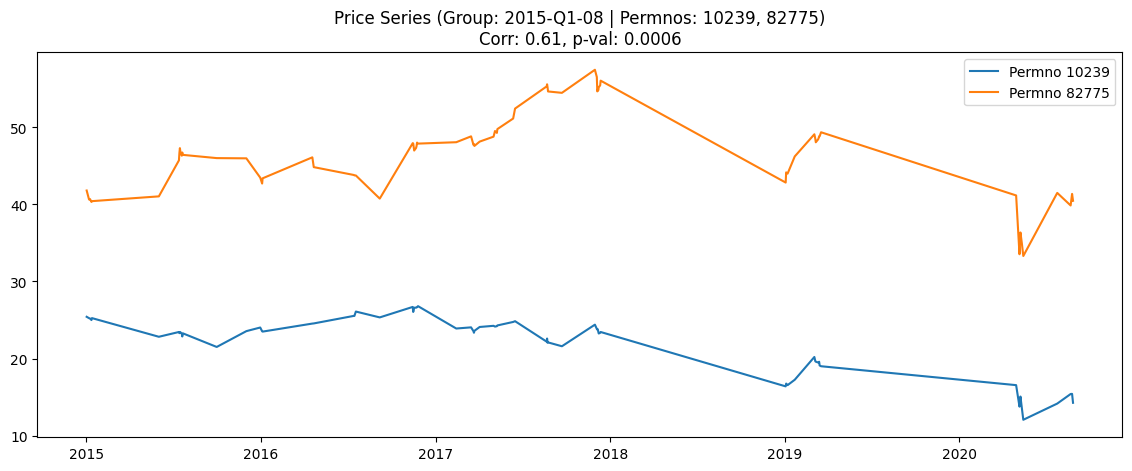

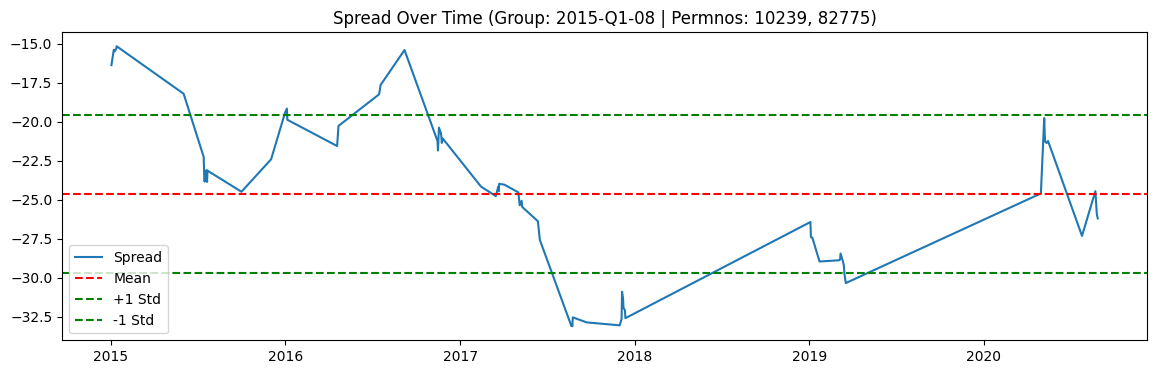

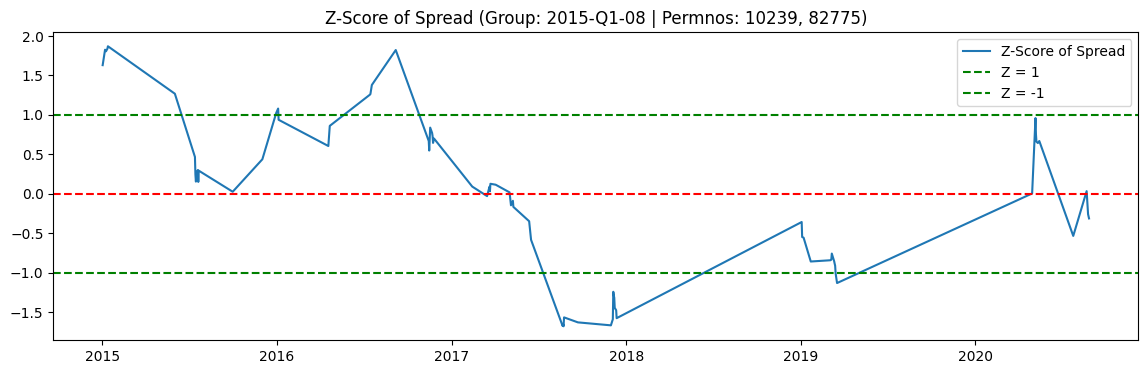

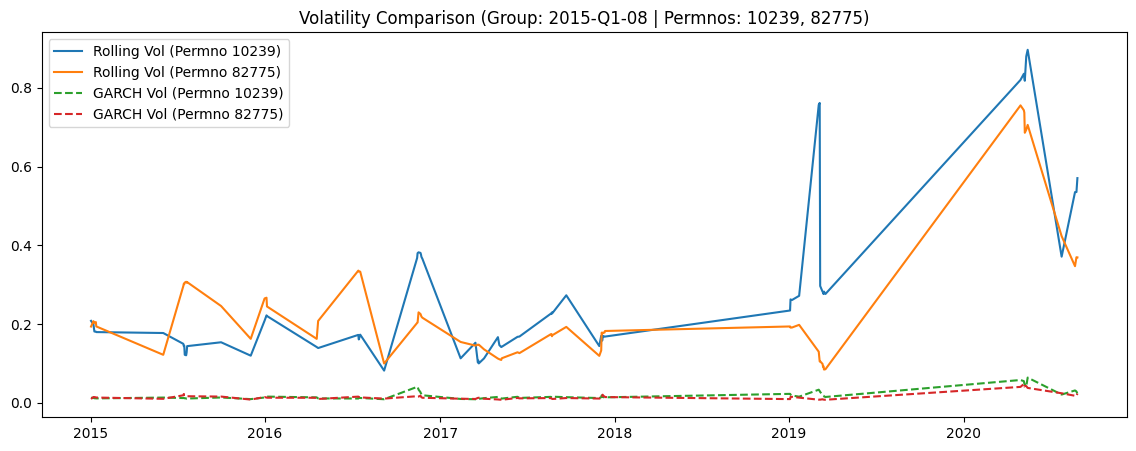

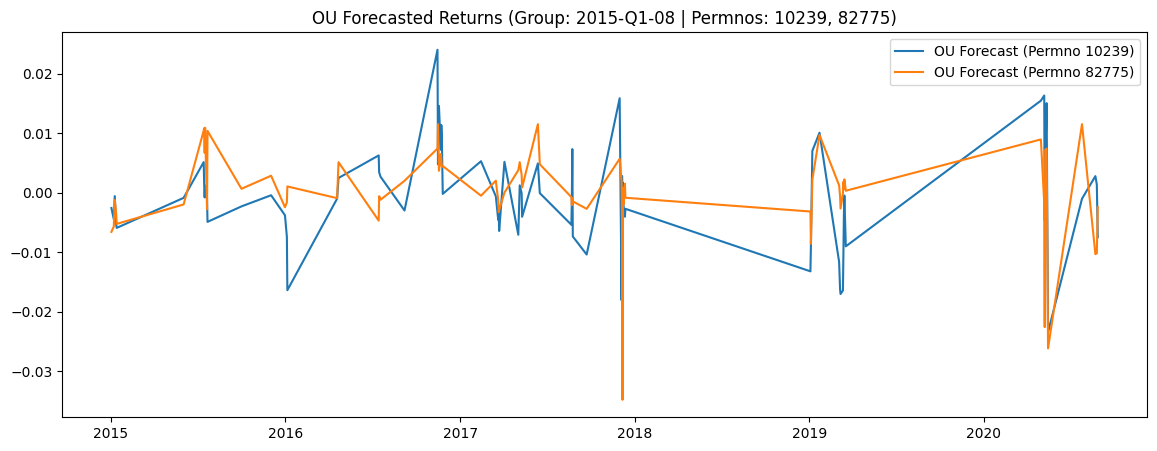

In [109]:
def plot_advanced_pair_analysis(df_final, merged_pairs, group_id):
    pair_info = merged_pairs[merged_pairs['group_id'] == group_id]
    if pair_info.empty:
        print(f"No pair found for group_id '{group_id}'")
        return

    permno_1 = int(pair_info.iloc[2]['permno_1'])
    permno_2 = int(pair_info.iloc[2]['permno_2'])
    correlation = pair_info.iloc[2]['correlation']
    p_value = pair_info.iloc[2]['p_value']

    # Filter data for the two securities
    df1 = df_final[df_final['permno'] == permno_1].copy()
    df2 = df_final[df_final['permno'] == permno_2].copy()

    df1 = df1[['date', 'adj_prc', 'rolling_vol_20d', 'garch_vol', 'realized_vol_5d', 'ou_forecast_return']].rename(columns={'adj_prc': 'price_1'})
    df2 = df2[['date', 'adj_prc', 'rolling_vol_20d', 'garch_vol', 'realized_vol_5d', 'ou_forecast_return']].rename(columns={'adj_prc': 'price_2'})

    df_pair = pd.merge(df1, df2, on='date', suffixes=('_1', '_2')).dropna()
    if df_pair.empty:
        print(f"No overlapping data for permno {permno_1} and {permno_2}")
        return

    # Spread and Z-Score Calculations
    df_pair['spread'] = df_pair['price_1'] - df_pair['price_2']
    mean_spread = df_pair['spread'].mean()
    std_spread = df_pair['spread'].std()
    df_pair['z_score_spread'] = (df_pair['spread'] - mean_spread) / std_spread

    title_suffix = f"(Group: {group_id} | Permnos: {permno_1}, {permno_2})"

    # ----------------- Plot 1: Price Series -----------------
    plt.figure(figsize=(14, 5))
    plt.plot(df_pair['date'], df_pair['price_1'], label=f'Permno {permno_1}')
    plt.plot(df_pair['date'], df_pair['price_2'], label=f'Permno {permno_2}')
    plt.title(f'Price Series {title_suffix}\nCorr: {correlation:.2f}, p-val: {p_value:.4f}')
    plt.legend()
    plt.show()

    # ----------------- Plot 2: Spread -----------------
    plt.figure(figsize=(14, 4))
    plt.plot(df_pair['date'], df_pair['spread'], label='Spread')
    plt.axhline(mean_spread, color='red', linestyle='--', label='Mean')
    plt.axhline(mean_spread + std_spread, color='green', linestyle='--', label='+1 Std')
    plt.axhline(mean_spread - std_spread, color='green', linestyle='--', label='-1 Std')
    plt.title(f'Spread Over Time {title_suffix}')
    plt.legend()
    plt.show()

    # ----------------- Plot 3: Z-Score of Spread -----------------
    plt.figure(figsize=(14, 4))
    plt.plot(df_pair['date'], df_pair['z_score_spread'], label='Z-Score of Spread')
    plt.axhline(0, color='red', linestyle='--')
    plt.axhline(1, color='green', linestyle='--', label='Z = 1')
    plt.axhline(-1, color='green', linestyle='--', label='Z = -1')
    plt.title(f'Z-Score of Spread {title_suffix}')
    plt.legend()
    plt.show()

    # ----------------- Plot 4: Volatility Comparison -----------------
    plt.figure(figsize=(14, 5))
    plt.plot(df_pair['date'], df_pair['rolling_vol_20d_1'], label=f'Rolling Vol (Permno {permno_1})')
    plt.plot(df_pair['date'], df_pair['rolling_vol_20d_2'], label=f'Rolling Vol (Permno {permno_2})')
    plt.plot(df_pair['date'], df_pair['garch_vol_1'], '--', label=f'GARCH Vol (Permno {permno_1})')
    plt.plot(df_pair['date'], df_pair['garch_vol_2'], '--', label=f'GARCH Vol (Permno {permno_2})')
    plt.title(f'Volatility Comparison {title_suffix}')
    plt.legend()
    plt.show()

    # ----------------- Plot 5: OU Forecast Return -----------------
    plt.figure(figsize=(14, 5))
    plt.plot(df_pair['date'], df_pair['ou_forecast_return_1'], label=f'OU Forecast (Permno {permno_1})')
    plt.plot(df_pair['date'], df_pair['ou_forecast_return_2'], label=f'OU Forecast (Permno {permno_2})')
    plt.title(f'OU Forecasted Returns {title_suffix}')
    plt.legend()
    plt.show()

# Example Usage
plot_advanced_pair_analysis(df_final, merged_pairs, group_id='2015-Q1-08')

## **Further analysis**

**Just for fun**

In [ ]:
# 📌 Calculate OU-Based Z-Score
df_merged['z_ou'] = (
    (df_merged['ou_forecast_return'] - df_merged['retx']) / df_merged['garch_vol']
)

In [ ]:
def evaluate_zscore_with_ou(df, horizons=[5, 10, 20]):
    results = []
    
    for h in horizons:
        # 📌 Calculate Rolling Mean and Std Dev for Classical Z-Score
        rolling_mean = (
            df.groupby('permno')['retx']
            .rolling(window=h, min_periods=int(h * 0.75))
            .mean()
            .reset_index(level=0, drop=True)
        )
        
        rolling_std = (
            df.groupby('permno')['retx']
            .rolling(window=h, min_periods=int(h * 0.75))
            .std()
            .reset_index(level=0, drop=True)
        )
        
        # Classical Z-Score for Current Horizon
        z_col = f'z_classical_{h}d'
        df[z_col] = (df['retx'] - rolling_mean) / rolling_std
        df[f'{z_col}_shifted'] = df[z_col].shift(1)  # Apply shift to avoid lookahead bias

        # Ensure OU-Based Z-Score is Shifted
        if 'z_ou_shifted' not in df.columns:
            df['z_ou_shifted'] = df['z_ou'].shift(1)

        # Prepare Valid Dataset with Both Classical and OU-Based Z-Scores Available
        valid = df.dropna(subset=[f'{z_col}_shifted', 'z_ou_shifted', 'future_return_1d'])

        # Calculate Hit Rates
        hit_rate_classical = (np.sign(valid[f'{z_col}_shifted']) == np.sign(valid['future_return_1d'])).mean()
        hit_rate_ou = (np.sign(valid['z_ou_shifted']) == np.sign(valid['future_return_1d'])).mean()

        results.append({
            'Hit Rate Classical (%)': hit_rate_classical * 100,
            'Hit Rate OU-Based (%)': hit_rate_ou * 100,
            'Unique Permnos': valid['permno'].nunique()
        })

    return pd.DataFrame(results)

# Ensure Future Return is Calculated
df_merged['future_return_1d'] = df_merged.groupby('permno')['retx'].shift(-1)

# Run Evaluation
evaluation_df = evaluate_zscore_with_ou(df_merged, horizons=[5, 10, 20])

evaluation_df

#### 📌 **Incorporating Volatility into OU Forecast**

In the deterministic OU forecast, we calculated only the expected mean return using:

$$
\mathbb{E}[X_{t+1}] = X_t \cdot e^{-\theta} + \mu \cdot \left(1 - e^{-\theta}\right)
$$

However, this ignores the randomness or uncertainty in returns.  
To introduce volatility into the forecast, we simulate a random shock using the following stochastic version of the OU process:

$$
X_{t+1} = \mathbb{E}[X_{t+1}] + \sigma \cdot \sqrt{1 - e^{-2\theta}} \cdot \varepsilon
$$

Where:
- $\mathbb{E}[X_{t+1}]$: Deterministic OU forecast (`ou_forecast_return`).
- $\sigma$: Volatility estimate, using **GARCH volatility** (`garch_vol`).
- $\theta$: Mean reversion speed parameter.
- $\varepsilon \sim \mathcal{N}(0, 1)$: A random value drawn from a standard normal distribution.



- `np.random.normal(0, 1, len(df_merged))` generates random shocks for each time period.
- `np.sqrt(1 - np.exp(-2 * df_merged['theta']))` adjusts the variance to account for discrete time steps.
- This creates a more realistic forecast by adding randomness, representing possible price movement uncertainty around the mean forecast.

The final stochastic forecast is stored in `ou_forecast_with_volatility`:

```python
df_merged['ou_forecast_with_volatility'] = (
    df_merged['ou_forecast_return'] + 
    df_merged['garch_vol'] * np.sqrt(1 - np.exp(-2 * df_merged['theta'])) * np.random.normal(0, 1, len(df_merged))
)


In [ ]:
# Assuming you already have ou_forecast_return, theta, and GARCH volatility columns

np.random.seed(42)  # For reproducibility

df_merged['ou_forecast_with_volatility'] = (
    df_merged['ou_forecast_return'] + 
    df_merged['garch_vol'] * np.sqrt(1 - np.exp(-2 * df_merged['theta'])) * np.random.normal(0, 1, len(df_merged))
)

In [ ]:
df_merged['z_ou_with_volatility'] = (
    (df_merged['ou_forecast_with_volatility'] - df_merged['retx']) / df_merged['garch_vol']
)

### 📖 **Evaluating Hit Rate for Trading Signals**

In this analysis, we evaluate the effectiveness of our trading signals by calculating the **Hit Rate** across different forecasting methods and time horizons.



#### 📌 **What Is Hit Rate?**

- Hit Rate measures the **percentage of times the trading signal correctly predicts the direction of future returns**.
- It focuses **only on the direction (up or down)**, not the magnitude of returns.
- A higher Hit Rate indicates that the signal is better at predicting whether the return will be positive or negative.

$$
\text{Hit Rate} = \frac{\text{Number of Correct Predictions}}{\text{Total Predictions}}
$$



We will use **Z-Scores** to generate signals for hit rate prediction.  
- A **positive Z-Score** indicates that the stock is expected to **rise** (suggesting a long position).  
- A **negative Z-Score** indicates that the stock is expected to **fall** (suggesting a short position).  

By comparing the predicted direction from Z-Scores with the actual future return, we can measure how many predictions were correct and how many were wrong.



#### 📚 **Z-Scores We Are Comparing:**



#### 1️⃣ **Classical Z-Score**

- Formula:

$$
Z_{\text{Classical}} = \frac{X_t - \mu_{\text{rolling}}}{\sigma_{\text{rolling}}}
$$

- Where:
  - $X_t$ = Current return (`retx`).
  - $\mu_{\text{rolling}}$ = Rolling mean of returns over a defined horizon (e.g., 5, 10, 20 days).
  - $\sigma_{\text{rolling}}$ = Rolling standard deviation of returns over the same horizon.



#### 2️⃣ **OU-Based Z-Score (Deterministic)**

- Formula:

$$
Z_{\text{OU}} = \frac{\mathbb{E}[X_{t+1}] - X_t}{\text{Volatility Estimate}}
$$

- Where:
  - $\mathbb{E}[X_{t+1}]$ = Forecasted return using the OU model (deterministic forecast).
    - Computed as:

    $$
    \mathbb{E}[X_{t+1}] = X_t \cdot e^{-\theta} + \mu \cdot \left(1 - e^{-\theta}\right)
    $$

  - $X_t$ = Current return (`retx`).
  - $\theta$ = Speed of mean reversion.
  - $\mu$ = Long-term average return (mean-reversion level).
  - Volatility Estimate = Typically GARCH-based volatility estimate.


#### 3️⃣ **OU-Based Z-Score (With Volatility)**

- Formula:

$$
Z_{\text{OU, Stochastic}} = \frac{X_{t+1}^{\text{stochastic}} - X_t}{\text{Volatility Estimate}}
$$

- Where:
  - $X_{t+1}^{\text{stochastic}} = \mathbb{E}[X_{t+1}] + \sigma \cdot \sqrt{1 - e^{-2\theta}} \cdot \varepsilon$
  - $\varepsilon \sim \mathcal{N}(0, 1)$ is a random shock (introduces randomness to the forecast).
  - $\sigma$ = GARCH-based volatility estimate.



By calculating and comparing these Z-Scores, we can assess how well each method predicts the direction of returns, using Hit Rate as the evaluation metric.

---


In [ ]:
def evaluate_zscore_with_ou(df, horizons=[5, 10, 20]):
    results = []
    
    for h in horizons:
        # 📌 Calculate Rolling Mean and Std Dev for Classical Z-Score
        rolling_mean = (
            df.groupby('permno')['retx']
            .rolling(window=h, min_periods=int(h * 0.75))
            .mean()
            .reset_index(level=0, drop=True)
        )
        
        rolling_std = (
            df.groupby('permno')['retx']
            .rolling(window=h, min_periods=int(h * 0.75))
            .std()
            .reset_index(level=0, drop=True)
        )
        
        # 📌 Classical Z-Score for Current Horizon
        z_col = f'z_classical_{h}d'
        df[z_col] = (df['retx'] - rolling_mean) / rolling_std
        df[f'{z_col}_shifted'] = df[z_col].shift(1)  # Avoid lookahead bias

        # 📌 Ensure OU-Based Z-Scores Are Shifted
        df['z_ou_shifted'] = df['z_ou'].shift(1)
        df['z_ou_with_volatility_shifted'] = df['z_ou_with_volatility'].shift(1)

        # 📌 Prepare Valid Dataset with All Required Columns
        valid = df.dropna(subset=[
            f'{z_col}_shifted', 
            'z_ou_shifted', 
            'z_ou_with_volatility_shifted', 
            'future_return_1d'
        ])

        # 📈 Calculate Hit Rates (Direction Prediction Accuracy)
        hit_rate_classical = (np.sign(valid[f'{z_col}_shifted']) == np.sign(valid['future_return_1d'])).mean()
        hit_rate_ou_det = (np.sign(valid['z_ou_shifted']) == np.sign(valid['future_return_1d'])).mean()
        hit_rate_ou_stochastic = (np.sign(valid['z_ou_with_volatility_shifted']) == np.sign(valid['future_return_1d'])).mean()

        result_row = {
            'Horizon (Days)': h,
            'Hit Rate Classical (%)': hit_rate_classical * 100,
            'Hit Rate OU (Deterministic) (%)': hit_rate_ou_det * 100,
            'Hit Rate OU (With Volatility) (%)': hit_rate_ou_stochastic * 100,
            'Unique Permnos': valid['permno'].nunique()
        }

        results.append(result_row)

    return pd.DataFrame(results)

# Ensure Future Return is Calculated
df_merged['future_return_1d'] = df_merged.groupby('permno')['retx'].shift(-1)

# Run Evaluation
evaluation_df = evaluate_zscore_with_ou(df_merged, horizons=[5, 10, 20])

evaluation_df

#### **Final Decision: Use Classical Z-Score with 5-Day Horizon**

Based on our evaluation, we observed that the **Classical Z-Score with a 5-day horizon** performs almost as well as the OU-based Z-Scores in terms of directional prediction (Hit Rate), while being much simpler to compute and implement.

However, the hit rate is only 46.58% of time, meaning the z-score direction prediction is only correct for 46.58% of the time. 



### **Analyzing hit rate for Modeling**
Now, that we have decided to take classical z-score let's analyze it to form a better strategy

#### Let's begin with hit rate based on permno (individual security)

In [ ]:
# Ensure Z-Score and future return columns are properly shifted and available
df_merged['z_classical_5d_shifted'] = df_merged['z_classical_5d'].shift(1)
df_merged['future_return_1d'] = df_merged.groupby('permno')['retx'].shift(-1)

# Filter out rows with missing values
valid_data = df_merged.dropna(subset=['z_classical_5d_shifted', 'future_return_1d'])

# Calculate Hit Indicator: 1 if correct direction, 0 otherwise
valid_data['hit_correct'] = (np.sign(valid_data['z_classical_5d_shifted']) == 
                             np.sign(valid_data['future_return_1d'])).astype(int)

# Calculate Hit Rate per permno
hit_rate_per_stock = valid_data.groupby('permno')['hit_correct'].mean().reset_index()
hit_rate_per_stock.rename(columns={'hit_correct': 'Hit Rate'}, inplace=True)

# Sort Stocks by Hit Rate (Descending)
hit_rate_per_stock = hit_rate_per_stock.sort_values('Hit Rate', ascending=False)

hit_rate_per_stock.head(10)  # Top 10 stocks with highest Hit Rate

In [ ]:
# Count number of permnos with Hit Rate greater than 70%
num_high_hit_rate_stocks = (hit_rate_per_stock['Hit Rate'] > 0.50).sum()

print(f"Number of stocks with Hit Rate > 50%: {num_high_hit_rate_stocks}")

#### 📖 **Does Speed and Long-Term Mean Have Any Relationship with Hit Rate?**

The **speed** ($\theta$) and **long-term mean** ($\mu$) are parameters in the **Ornstein-Uhlenbeck (OU) forecast**, which models mean-reverting behavior of stock returns.



- **$X_t$ (Current Value):**  
  - In our implementation, $X_t$ represents the **daily price return excluding dividends**, calculated from stock price changes.  
  - This is the value from the `retx` column in the dataset.



- **Speed ($\theta$):**  
  - Represents **how quickly returns revert to their long-term mean**.  
  - Higher $\theta$ → Faster reversion.  
  - Calculated from the regression equation:  

    $$
    \theta = -\ln(\beta)
    $$  

    where $\beta$ is the slope coefficient from the regression equation:

    $$
    X_t = \beta X_{t-1} + c
    $$  

- **Long-Term Mean ($\mu$):**  
  - Represents the **average return level** the stock tends to revert to over time.  
  - Calculated as:  

    $$
    \mu = \frac{c}{1 - \beta}
    $$  

    where $c$ is the intercept from the same regression.



Let's try to visualize their relationships with Hit Rate to check if we can incorporate them into our trading strategy for improving signal effectiveness.

In [ ]:
hit_analysis_df = hit_rate_per_stock.merge(ou_df, on='permno', how='inner')
hit_analysis_df

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=hit_analysis_df, x='theta', y='Hit Rate')
plt.title("Relationship Between Mean Reversion Speed (θ) and Signal Hit Rate")
plt.xlabel("Theta (Speed of Mean Reversion)")
plt.ylabel("Z-Score Hit Rate")
plt.grid(True)
plt.show()

In [ ]:
correlation = hit_analysis_df[['theta', 'Hit Rate']].corr().iloc[0,1]
print(f"Correlation between theta and Hit Rate: {correlation:.4f}")

In [ ]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=hit_analysis_df, x='mu', y='Hit Rate')
plt.title("Relationship Between Long-Term Mean ($\mu$) and Hit Rate")
plt.xlabel("Mu (Long-Term Mean Return)")
plt.ylabel("Z-Score Hit Rate")
plt.grid(True)
plt.show()


In [ ]:
correlation_mu = hit_analysis_df[['mu', 'Hit Rate']].corr().iloc[0, 1]
print(f"Correlation between mu and Hit Rate: {correlation_mu:.4f}")


In [ ]:
from scipy.stats import binomtest

In [ ]:
# 'valid_data' has 'permno' and 'hit_correct' columns

# Calculate total trades and correct predictions per stock
hit_summary = valid_data.groupby('permno').agg(
    correct_predictions=('hit_correct', 'sum'),
    total_trades=('hit_correct', 'count')
).reset_index()

# Calculate p-values for each stock
hit_summary['p_value'] = hit_summary.apply(
    lambda row: binomtest(int(row['correct_predictions']), int(row['total_trades']), p=0.5, alternative='greater').pvalue,
    axis=1
)

# Filter for statistically significant stocks
significant_stocks = hit_summary[hit_summary['p_value'] < 0.05]

significant_stocks

In [ ]:
significance_rate = (hit_summary['p_value'] < 0.05).mean() * 100
print(f"Percentage of Stocks with Significant Hit Rates: {significance_rate:.2f}%")


In [ ]:
hit_summary

In [ ]:
df_merged.columns

### 📖 Analysis: Investigating the Impact of GARCH Volatility on Trading Signal Accuracy 

In this analysis, we explore whether the level of GARCH-estimated volatility has any relationshp with the accuracy of trading signals generated using classical SD based z-scores.

- Calculate the correctness of each prediction by comparing the predicted return direction (from lagged z-scores) with the actual future return.
- Use GARCH volatility to segment the data into 10 equal-sized buckets (deciles), from lowest to highest volatility periods.
- Calculate and plot the hit rate for each volatility decile to observe how signal accuracy changes with market volatility.


In [ ]:
# Remove rows with missing data
valid_data = df_merged.dropna(subset=['z_classical_5d_shifted', 'future_return_1d']).copy()

# Calculate the hit correctness
valid_data.loc[:, 'hit_correct'] = (
    np.sign(valid_data['z_classical_5d_shifted']) == np.sign(valid_data['future_return_1d'])
).astype(int)

# Bucket GARCH volatility within valid_data only (not df_merged)
valid_data.loc[:, 'garch_vol_bucket'] = pd.qcut(valid_data['garch_vol'], q=10, labels=False)

# Calculate hit rate by GARCH volatility bucket
hit_rate_by_vol = valid_data.groupby('garch_vol_bucket')['hit_correct'].mean().reset_index()

# Plotting
plt.figure(figsize=(8, 5))
sns.lineplot(data=hit_rate_by_vol, x='garch_vol_bucket', y='hit_correct')
plt.xlabel("GARCH Volatility Decile (0 = Low Vol, 9 = High Vol)")
plt.ylabel("Hit Rate")
plt.title("Hit Rate vs. GARCH Volatility Buckets")
plt.grid(True)
plt.show()

Even though there is a clear signal that decrease in the GARCH volatility Decile shows strong z-score direction, hit rate is still below 50% for the first decile. So, let's create 100 quantile-based buckets to get clear overview

In [ ]:
# Create 100 quantile-based buckets
valid_data.loc[:, 'garch_vol_bucket_100'] = pd.qcut(valid_data['garch_vol'], q=100, labels=False)

# Calculate hit rate by the new 100 buckets
hit_rate_by_vol_100 = valid_data.groupby('garch_vol_bucket_100')['hit_correct'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 5))
sns.lineplot(data=hit_rate_by_vol_100, x='garch_vol_bucket_100', y='hit_correct')
plt.xlabel("GARCH Volatility Percentile (0 = Lowest Vol, 99 = Highest Vol)")
plt.ylabel("Hit Rate")
plt.title("Hit Rate vs. GARCH Volatility Percentiles (100 Buckets)")
plt.grid(True)
plt.show()

### 📊 Summary 

Even though theres is no significant difference between 100 quantile hit rates and 10 deciles hit rate, the charts clearly shows that as GARCH volatility increases, the hit rate of our trading signals declines. This indicates that our z-score signals are more effective in **low volatility environments** and tend to perform poorly during **high volatility periods**.

#### ✅ **Implications for Modeling:**
- **Trade Filtering:**  
  Execute trades only when GARCH volatility is within lower deciles (e.g., 0–3), avoiding high volatility periods where signals are less reliable.
  
- **Position Sizing:**  
  Apply **inverse volatility weighting** to allocate larger positions during low volatility regimes and smaller positions during high volatility regimes.

- **Dynamic Thresholding:**  
  Adjust z-score entry thresholds based on volatility regimes—require stronger signals during high volatility periods to reduce false positives.

Incorporating GARCH volatility into the trading framework allows for better risk management and enhances the effectiveness of mean-reversion strategies by focusing on periods where the strategy has historically performed better.

### **Mean Reversion Analysis**
### For further analysis let's only take relavant columns and non nan rows

In [ ]:
# Required columns
required_columns = ['rolling_vol_5d_daily', 'garch_vol', 'garch_vol_annualized', 
                    'z_classical_5d', 'z_classical_5d_shifted']

# Filter columns that have 0 nulls and are in required_columns
columns_with_no_null = df_merged.columns[(df_merged.isnull().sum() == 0)]
print(columns_with_no_null)
final_columns = required_columns + list(columns_with_no_null)

# Final filtered DataFrame
df_filtered = df_merged[final_columns]

df_filtered = df_filtered.dropna()

df_filtered.isnull().sum()

In [ ]:
df_filtered

In [ ]:
# Calculate average return for each group_id and date
df_filtered['group_avg_return'] = df_filtered.groupby(['group_id', 'date'])['retx'].transform('mean')

# Calculate each stock's return relative to its group average
df_filtered['retx_relative'] = df_filtered['retx'] - df_filtered['group_avg_return']

In [ ]:
# Rank stocks within group
df_filtered['group_rank'] = df_filtered.groupby(['group_id', 'date'])['retx'].rank()

### 📖 After Extreme Deviations

In this analysis, we investigate whether stocks that significantly deviate from their peer group’s average return (`retx_relative`) tend to mean revert in the short term.


#### 🧪 Approach

- Identify extreme values of `retx_relative` using the top and bottom 5% thresholds.
- Calculate future cumulative returns over multiple holding periods (1, 3, 5, and 10 days).
- Plot average future returns following:
  - **Long positions** (stocks that underperformed their group — bottom 5%)
  - **Short positions** (stocks that outperformed their group — top 5%)

This allows us to evaluate whether such relative return extremes are followed by price corrections, i.e., mean reversion.

In [ ]:
# Define extreme thresholds (e.g., top and bottom 5% relative returns)
lower_threshold = df_filtered['retx_relative'].quantile(0.10)
upper_threshold = df_filtered['retx_relative'].quantile(0.90)

print(lower_threshold)
print(upper_threshold)

In [ ]:
(df_filtered['retx_relative'] > 0).mean()

In [ ]:
df_filtered['retx'].quantile(0.30)

In [ ]:
# Create future return columns
for h in [1, 3, 5, 10]:  # 1-day, 3-day, 5-day, and 10-day forward returns
    df_filtered[f'future_cumret_{h}d'] = df_filtered.groupby('permno')['retx'].shift(-h).rolling(h).sum().reset_index(level=0, drop=True)

# Analyze mean future returns after extreme deviations
long_returns = df_filtered[df_filtered['retx_relative'] <= lower_threshold][[f'future_cumret_{h}d' for h in [1, 3, 5, 10]]].mean()
short_returns = df_filtered[df_filtered['retx_relative'] >= upper_threshold][[f'future_cumret_{h}d' for h in [1, 3, 5, 10]]].mean()

# Plot the results
plt.figure(figsize=(8,5))
plt.plot([1, 3, 5, 10], long_returns, marker='o', label='Long (Low retx_relative)')
plt.plot([1, 3, 5, 10], -short_returns, marker='o', label='Short (High retx_relative)')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Holding Period (Days)")
plt.ylabel("Average Future Cumulative Return")
plt.title("Mean Reversion Analysis After Extreme Deviations")
plt.legend()
plt.grid(True)
plt.show()


### 📊 Findings

The plot demonstrates that **mean reversion is not strongly observed** in the data:

- **Long trades** (after underperformance) generate **positive returns** and is **profitable**, but the effect is weak.
- **Short trades** (after outperformance) show **positive future returns**, meaning shorting these will generate **losses** as showin in the above graph. This indicates that previous winners tend to continue performing well.

This suggests that the market dynamics in the analyzed period exhibit **momentum behavior**, where trends persist rather than reverse.


### 📌 Implications for Strategy

- **Signal Caution:** The `retx_relative` variable alone is not sufficient to reliably capture profitable mean-reversion opportunities.
- **Market Behavior:** Short-term momentum seems to dominate, especially within peer groups, reducing the effectiveness of a pure mean-reversion strategy.

#### Lets only consider Low GARCH volatility periods

In [ ]:
# Define low volatility as bottom 30% of GARCH volatility (you can adjust this threshold)
low_vol_threshold = df_filtered['garch_vol'].quantile(0.20)
df_low_vol = df_filtered[df_filtered['garch_vol'] <= low_vol_threshold]

In [ ]:
# Redefine thresholds for extreme deviations within low volatility periods
lower_threshold_low_vol = df_low_vol['retx_relative'].quantile(0.30)
upper_threshold_low_vol = df_low_vol['retx_relative'].quantile(0.70)

# Create future return columns if not already created
for h in [1, 3, 5, 10]:
    df_low_vol[f'future_cumret_{h}d'] = (
        df_low_vol.groupby('permno')['retx'].shift(-h).rolling(h).sum().reset_index(level=0, drop=True)
    )

# Analyze mean future returns after extreme deviations in low volatility
long_returns_low_vol = df_low_vol[df_low_vol['retx_relative'] <= lower_threshold_low_vol][[f'future_cumret_{h}d' for h in [1, 3, 5, 10]]].mean()
short_returns_low_vol = df_low_vol[df_low_vol['retx_relative'] >= upper_threshold_low_vol][[f'future_cumret_{h}d' for h in [1, 3, 5, 10]]].mean()

# Plot
plt.figure(figsize=(8, 5))
plt.plot([1, 3, 5, 10], long_returns_low_vol, marker='o', label='Long (Low retx_relative)')
plt.plot([1, 3, 5, 10], -short_returns_low_vol, marker='o', label='Short (High retx_relative)')  # Plotting profits
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Holding Period (Days)")
plt.ylabel("Average Future Cumulative Return")
plt.title("Mean Reversion in Low GARCH Volatility Periods")
plt.legend()
plt.grid(True)
plt.show()

- Even in the low vol, our short position will be generating losses. Both the underperforming and outperforming stocks tend to move in upward direction. This shows no mean reversion in KNN based peer portfolios

#### **Let's check on portfolios**
Is there any group where mean reversion might work. and if yes, how many such group exist?

In [ ]:
group_analysis_results = []

for group_id, group_df in df_filtered.groupby('group_id'):
    lower_threshold = group_df['retx_relative'].quantile(0.05)
    upper_threshold = group_df['retx_relative'].quantile(0.95)
    
    long_future_return = group_df[group_df['retx_relative'] <= lower_threshold]['future_cumret_5d'].mean()
    short_future_return = group_df[group_df['retx_relative'] >= upper_threshold]['future_cumret_5d'].mean()
    
    group_analysis_results.append({
        'group_id': group_id,
        'long_avg_return_5d': long_future_return,
        'short_avg_return_5d': short_future_return
    })

group_analysis_df = pd.DataFrame(group_analysis_results)


In [ ]:
# Mean reversion should have long returns > 0 and short returns < 0
mean_reversion_groups = group_analysis_df[
    (group_analysis_df['long_avg_return_5d'] > 0) & 
    (group_analysis_df['short_avg_return_5d'] < 0)
]

print(f"Number of groups where mean reversion works: {len(mean_reversion_groups)}")
display(mean_reversion_groups.sort_values(by='long_avg_return_5d', ascending=False))

In [ ]:
total_groups = group_analysis_df['group_id'].nunique()
mean_reversion_groups_count = len(mean_reversion_groups)

# Calculate percentage
mean_reversion_percentage = (mean_reversion_groups_count / total_groups) * 100

print(f"📊 Total Groups Analyzed: {total_groups}")
print(f"✅ Groups Showing Mean Reversion: {mean_reversion_groups_count}")
print(f"📈 Percentage of Groups with Mean Reversion: {mean_reversion_percentage:.2f}%")


In [ ]:
# Extract year from group_id (assuming it's like '1976-Q1-07')
mean_reversion_groups['year'] = mean_reversion_groups['group_id'].str[:4]

# Calculate how many groups showed mean reversion per year
mean_reversion_by_year = mean_reversion_groups.groupby('year').size().reset_index(name='mean_reversion_groups')

# Also calculate total groups per year for percentage calculation
group_analysis_df['year'] = group_analysis_df['group_id'].str[:4]
total_groups_by_year = group_analysis_df.groupby('year').size().reset_index(name='total_groups')

# Merge and calculate percentage
yearly_stats = pd.merge(mean_reversion_by_year, total_groups_by_year, on='year')
yearly_stats['mean_reversion_percentage'] = (yearly_stats['mean_reversion_groups'] / yearly_stats['total_groups']) * 100
yearly_stats

There are only 17.68% group where mean reversion would work. There's also atleast 1 group every year where mean reversion would work.

### **Now, let's look for trend following strategy**

In [ ]:
# Define thresholds for identifying trending stocks
lower_threshold = df_filtered['retx_relative'].quantile(0.05)  # Underperformers (trend-following short)
upper_threshold = df_filtered['retx_relative'].quantile(0.95)  # Outperformers (trend-following long)

# Ensure future returns are calculated
for h in [1, 3, 5, 10]:
    df_filtered[f'future_cumret_{h}d'] = (
        df_filtered.groupby('permno')['retx'].shift(-h).rolling(h).sum().reset_index(level=0, drop=True)
    )

# Analyze mean future returns after extreme performance (trend-following)
long_returns_trend = df_filtered[df_filtered['retx_relative'] >= upper_threshold][[f'future_cumret_{h}d' for h in [1, 3, 5, 10]]].mean()
short_returns_trend = df_filtered[df_filtered['retx_relative'] <= lower_threshold][[f'future_cumret_{h}d' for h in [1, 3, 5, 10]]].mean()

# Plotting
plt.figure(figsize=(8, 5))
plt.plot([1, 3, 5, 10], long_returns_trend, marker='o', label='Long (Trend Followers - High retx_relative)')
plt.plot([1, 3, 5, 10], -short_returns_trend, marker='o', label='Short (Trend Followers - Low retx_relative)')  # Profit perspective
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Holding Period (Days)")
plt.ylabel("Average Future Cumulative Return")
plt.title("Trend-Following Analysis Based on retx_relative")
plt.legend()
plt.grid(True)
plt.show()

Even in trend following our short positions doesn't generate profit. Seems not working.

In [ ]:
short_returns_trend

In [ ]:
# Example: Correlation between adj_prc and group_avg_return
pearson_corr = df_filtered['adj_prc'].corr(df_filtered['group_avg_return'])
spearman_corr = df_filtered['adj_prc'].corr(df_filtered['group_avg_return'], method='spearman')

print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")

In [ ]:
def plot_pair_trading_signal(df, permno1, permno2, log_transform=True):
    # Filter data for the two stocks
    s1 = df[df['permno'] == permno1][['date', 'adj_prc']].dropna()
    s2 = df[df['permno'] == permno2][['date', 'adj_prc']].dropna()
    
    # Merge on date to align time series
    merged = pd.merge(s1, s2, on='date', suffixes=('_1', '_2'))
    
    if len(merged) < 50:
        print("Insufficient overlapping data.")
        return
    
    # Optionally log-transform prices
    p1 = np.log(merged['adj_prc_1']) if log_transform else merged['adj_prc_1']
    p2 = np.log(merged['adj_prc_2']) if log_transform else merged['adj_prc_2']
    
    # Estimate hedge ratio using OLS
    model = OLS(p1, add_constant(p2)).fit()
    beta = model.params[1]
    
    # Calculate spread
    spread = p1 - beta * p2
    mean_spread = spread.mean()
    std_spread = spread.std()
    
    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    # Price Series Plot
    axes[0].plot(merged['date'], merged['adj_prc_1'], label=f'Permno {permno1}')
    axes[0].plot(merged['date'], merged['adj_prc_2'], label=f'Permno {permno2}')
    axes[0].set_title('Price Series')
    axes[0].legend()
    axes[0].grid(True)
    
    # Spread Plot with Mean and Thresholds
    axes[1].plot(merged['date'], spread, label='Spread', color='purple')
    axes[1].axhline(mean_spread, color='black', linestyle='--', label='Mean')
    axes[1].axhline(mean_spread + std_spread, color='red', linestyle='--', label='+1 Std Dev')
    axes[1].axhline(mean_spread - std_spread, color='green', linestyle='--', label='-1 Std Dev')
    axes[1].set_title('Spread and Trading Thresholds')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Hedge Ratio (Beta): {beta:.4f}")
    print(f"Spread Mean: {mean_spread:.4f}, Spread Std Dev: {std_spread:.4f}")


In [ ]:
def get_ticker(permno, df_mapping):
    result = df_mapping[df_mapping['permno'] == permno]['ticker']
    return result.values[0] if not result.empty else None

In [ ]:
def correlation_analysis_by_group(df, min_obs=50, method='pearson'):
    correlation_pairs = []
    insufficient_data_pairs = []

    for group in df['group_id'].unique():
        group_df = df[df['group_id'] == group]
        permnos = group_df['permno'].unique()

        for permno1, permno2 in itertools.combinations(permnos, 2):
            s1 = group_df[group_df['permno'] == permno1][['date', 'adj_prc']].dropna()
            s2 = group_df[group_df['permno'] == permno2][['date', 'adj_prc']].dropna()

            merged = pd.merge(s1, s2, on='date', suffixes=('_1', '_2'))
            common_dates = len(merged)

            if common_dates < min_obs:
                insufficient_data_pairs.append({
                    'group_id': group,
                    'permno1': permno1,
                    'permno2': permno2,
                    'common_dates': common_dates
                })
                continue

            corr_value = merged['adj_prc_1'].corr(merged['adj_prc_2'], method=method)
            correlation_pairs.append({
                'group_id': group,
                'permno1': permno1,
                'permno2': permno2,
                'correlation': corr_value,
                'num_observations': common_dates
            })

    return pd.DataFrame(correlation_pairs), pd.DataFrame(insufficient_data_pairs)

# Run correlation analysis
correlation_pairs_df, insufficient_corr_data_df = correlation_analysis_by_group(df_filtered)

# View Results
print("High Correlation Pairs:")
print(correlation_pairs_df.sort_values('correlation', ascending=False))

print("\nPairs with Insufficient Data for Correlation:")
print(insufficient_corr_data_df.sort_values('common_dates', ascending=False))

In [ ]:
plot_pair_trading_signal(df_filtered, 16021, 93422, log_transform=True)

In [ ]:
plot_pair_trading_signal(df_filtered, 50606, 84808, log_transform=True)

In [ ]:
ticker1 = 11394
ticker2 = 17041
print(get_ticker(ticker1, df_filtered))
print(get_ticker(ticker2, df_filtered))